In [1]:
import numpy as np
import pandas as pd
import shap
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(11.7,8.27)})

from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, plot_confusion_matrix, classification_report

import lightgbm as lgb

from aux_functions import fit_line, invert_regr

In [2]:
df_public = pd.read_csv('csv_data/df_public_test.csv', index_col='Unnamed: 0')
df_private = pd.read_csv('csv_data/df_private_test.csv', index_col='Unnamed: 0')

In [3]:
df_NR = pd.read_csv('csv_data/df_NR.csv', index_col='Unnamed: 0')
df_ER = pd.read_csv('csv_data/df_ER.csv', index_col='Unnamed: 0')
df = pd.concat([df_NR, df_ER])

In [4]:
df.head()

,N_bkgr_only_x,N_bkgr_only_y,N_error_bkgr_only_x,N_error_bkgr_only_y,N_error_x,N_error_y,N_x,N_y,bkgr_count_x,bkgr_count_y,...,sigma_x,sigma_y,tolerance_bkgr_only_x,tolerance_bkgr_only_y,tolerance_x,tolerance_y,up_bkgr_only_x,up_bkgr_only_y,up_x,up_y
0,1.445476e+06,1.445571e+06,1202.279529,1202.319211,1202.281860,1202.319856,1.445482e+06,1.445573e+06,1.446074e+06,1.445101e+06,...,1.418332,3.067164,0.1,0.1,0.1,0.1,1.0,1.0,1.0,1.0
1,1.444762e+06,1.444869e+06,1201.982422,1202.027072,0.000000,1202.028233,1.832608e+06,1.444872e+06,1.331175e+06,1.443962e+06,...,206.965796,5.779184,0.1,0.1,0.1,0.1,1.0,1.0,1.0,1.0
2,1.457226e+06,1.457315e+06,1207.156241,1207.193097,1207.305566,1207.349531,1.457587e+06,1.457693e+06,1.446322e+06,1.446692e+06,...,6.413964,5.924996,0.1,0.1,0.1,0.1,1.0,1.0,1.0,1.0
3,1.447220e+06,1.447342e+06,1203.004409,1203.055289,1203.015877,1203.065822,1.447247e+06,1.447367e+06,1.443786e+06,1.444582e+06,...,7.764097,5.870479,0.1,0.1,0.1,0.1,1.0,1.0,1.0,1.0
4,1.447794e+06,1.447899e+06,1203.243010,1203.286578,1203.256044,1203.296514,1.447825e+06,1.447923e+06,1.444089e+06,1.445411e+06,...,7.908807,5.172748,0.1,0.1,0.1,0.1,1.0,1.0,1.0,1.0


In [5]:
# feat_list = ['N_error_x', 'N_error_y', 'N_x', 'N_y', 'bkgr_count_x', 'bkgr_count_y',
#        'chi2_pvalue_x', 'chi2_pvalue_y', 'chi2_x', 'chi2_y', 'dfr', 'dmu',
#        'dsigma', 'edm_x', 'edm_y', 'event_ID', 'event_angle', 'event_class',
#        'event_energy', 'fr_error_x', 'fr_error_y', 'fr_x', 'fr_y', 'fval_x',
#        'fval_y', 'has_accurate_covar_x', 'has_accurate_covar_y',
#        'has_covariance_x', 'has_covariance_y', 'has_made_posdef_covar_x',
#        'has_made_posdef_covar_y',
#        'has_posdef_covar_x', 'has_posdef_covar_y',
#        'has_reached_call_limit_x', 'has_reached_call_limit_y',
#        'hesse_failed_x', 'hesse_failed_y', 'image_name',
#         'is_valid_x', 'is_valid_y', 'mu_error_x',
#        'mu_error_y', 'mu_x', 'mu_y', 'n_excess_bins_x', 'n_excess_bins_y',
#        'nfcn_total_x', 'nfcn_total_y', 'nfcn_x', 'nfcn_y', 'ngrad_total_x',
#        'ngrad_total_y', 'ngrad_x', 'ngrad_y', 'sig_count_x', 'sig_count_y',
#        'sig_density_x', 'sig_density_y', 'sigma_error_x', 'sigma_error_y',
#        'sigma_x', 'sigma_y',]

In [6]:
# df = df[feat_list]

In [7]:
df['sig_count_x_over_E'] = df['sig_count_x'] / df['event_energy']
df['sig_count_y_over_E'] = df['sig_count_y'] / df['event_energy']
# df['dsig_count'] = df['sig_count_x'] - df['sig_count_y']
# df_public['dsig_count'] = df_public['sig_count_x'] - df_public['sig_count_y']
# df_private['dsig_count'] = df_private['sig_count_x'] - df_private['sig_count_y']

### boxplots

In [8]:
cut = 'sig_count_x > 0 and sig_count_x < 1.e5 and sig_count_y > 0 and sig_count_y < 1.e5'
# cut += ' and event_energy < 30 and event_energy > 1'  
cut += ' and fr_x > 1.e-5 and fr_y > 1.e-5 and sigma_x < 10 and sigma_y < 10'
# cut += ' and chi2_pvalue_y > 0.05 and dmu < 1'

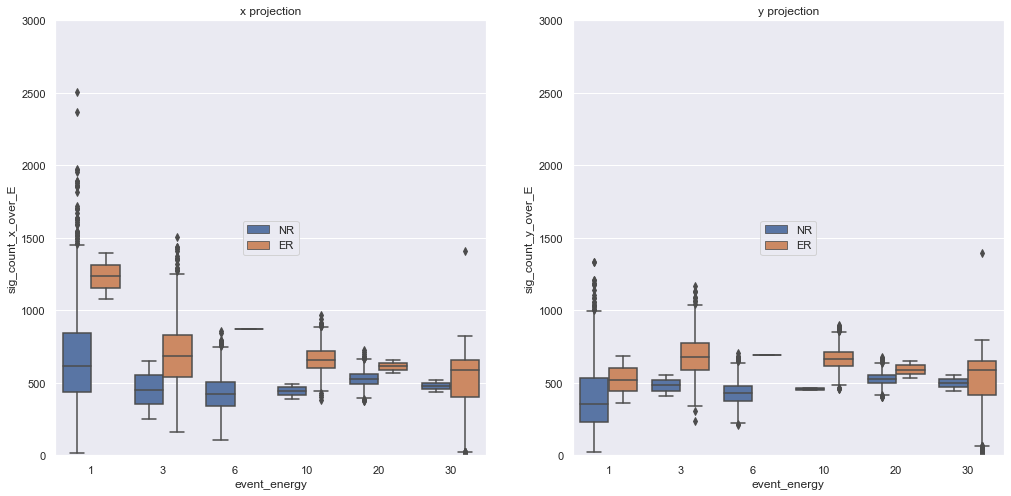

In [9]:
f, axes = plt.subplots(1, 2, figsize=(17,8))
for ax, proj in zip(axes, ['x', 'y']):
    ax.set_ylim(0, 3000)
    ax.set_title(f'{proj} projection')
    g = sns.boxplot(x='event_energy', y=f'sig_count_{proj}_over_E', hue='event_class', data=df.query(cut), ax=ax)
    g.legend(loc='center')

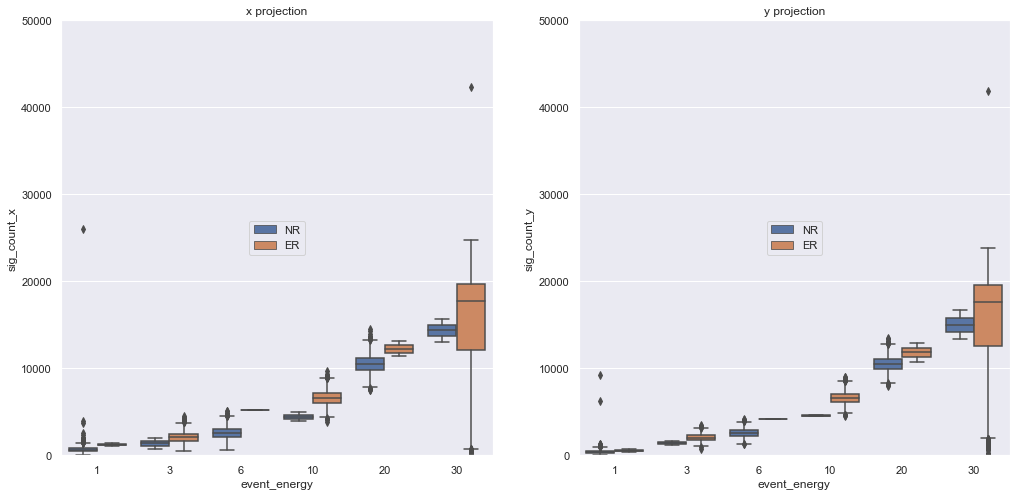

In [10]:
f, axes = plt.subplots(1, 2, figsize=(17,8))
for ax, proj in zip(axes, ['x', 'y']):
    ax.set_ylim(0, 50000)
    ax.set_title(f'{proj} projection')
    g = sns.boxplot(x='event_energy', y=f'sig_count_{proj}', hue='event_class', data=df.query(cut), ax=ax)
    g.legend(loc='center')

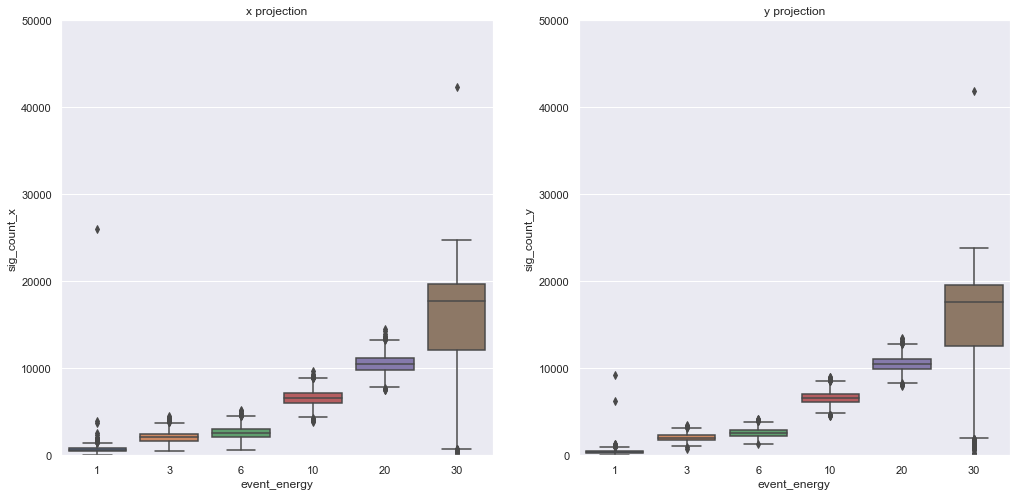

In [11]:
f, axes = plt.subplots(1, 2, figsize=(17,8))
for ax, proj in zip(axes, ['x', 'y']):
    ax.set_ylim(0, 50000)
    ax.set_title(f'{proj} projection')
    g = sns.boxplot(x='event_energy', y=f'sig_count_{proj}', data=df.query(cut), ax=ax)

### dev

In [12]:
cut

'sig_count_x > 0 and sig_count_x < 1.e5 and sig_count_y > 0 and sig_count_y < 1.e5 and fr_x > 1.e-5 and fr_y > 1.e-5 and sigma_x < 10 and sigma_y < 10'

In [13]:
bw_adjust = 0.3

In [14]:
# f, axes = plt.subplots(1, 2, figsize=(17,8))
# for ax, ec in zip(axes, ['NR', 'ER']):
#     ax.set_title(ec)
#     ax.set_xlim(0, 25000)
#     sns.kdeplot(df.query(cut + ' and event_energy == 1' + f'and event_class == "{ec}"').sig_count_x, bw_adjust=bw_adjust, linewidth=3, ax=ax, label='1 keV')
#     sns.kdeplot(df.query(cut + ' and event_energy == 3' + f'and event_class == "{ec}"').sig_count_x, bw_adjust=bw_adjust, linewidth=3, ax=ax, label='3 keV')
#     sns.kdeplot(df.query(cut + ' and event_energy == 6' + f'and event_class == "{ec}"').sig_count_x, bw_adjust=bw_adjust, linewidth=3, ax=ax, label='6 keV')
#     sns.kdeplot(df.query(cut + ' and event_energy == 10' + f'and event_class == "{ec}"').sig_count_x, bw_adjust=bw_adjust, linewidth=3, ax=ax, label='10 keV')
#     sns.kdeplot(df.query(cut + ' and event_energy == 20' + f'and event_class == "{ec}"').sig_count_x, bw_adjust=bw_adjust, linewidth=3, ax=ax, label='20 keV')
#     sns.kdeplot(df.query(cut + ' and event_energy == 30' + f'and event_class == "{ec}"').sig_count_x, bw_adjust=bw_adjust, linewidth=3, ax=ax, label='30 keV')
#     ax.legend()
# plt.show()

In [15]:
# f, axes = plt.subplots(1, 2, figsize=(17,8))
# for ax, ec in zip(axes, ['NR', 'ER']):
#     ax.set_title(ec)
#     ax.set_xlim(0, 25000)
#     sns.kdeplot(df.query(cut + ' and event_energy == 1' + f'and event_class == "{ec}"').sig_count_y, bw_adjust=bw_adjust, linewidth=3, ax=ax, label='1 keV')
#     sns.kdeplot(df.query(cut + ' and event_energy == 3' + f'and event_class == "{ec}"').sig_count_y, bw_adjust=bw_adjust, linewidth=3, ax=ax, label='3 keV')
#     sns.kdeplot(df.query(cut + ' and event_energy == 6' + f'and event_class == "{ec}"').sig_count_y, bw_adjust=bw_adjust, linewidth=3, ax=ax, label='6 keV')
#     sns.kdeplot(df.query(cut + ' and event_energy == 10' + f'and event_class == "{ec}"').sig_count_y, bw_adjust=bw_adjust, linewidth=3, ax=ax, label='10 keV')
#     sns.kdeplot(df.query(cut + ' and event_energy == 20' + f'and event_class == "{ec}"').sig_count_y, bw_adjust=bw_adjust, linewidth=3, ax=ax, label='20 keV')
#     sns.kdeplot(df.query(cut + ' and event_energy == 30' + f'and event_class == "{ec}"').sig_count_y, bw_adjust=bw_adjust, linewidth=3, ax=ax, label='30 keV')
#     ax.legend()
# plt.show()

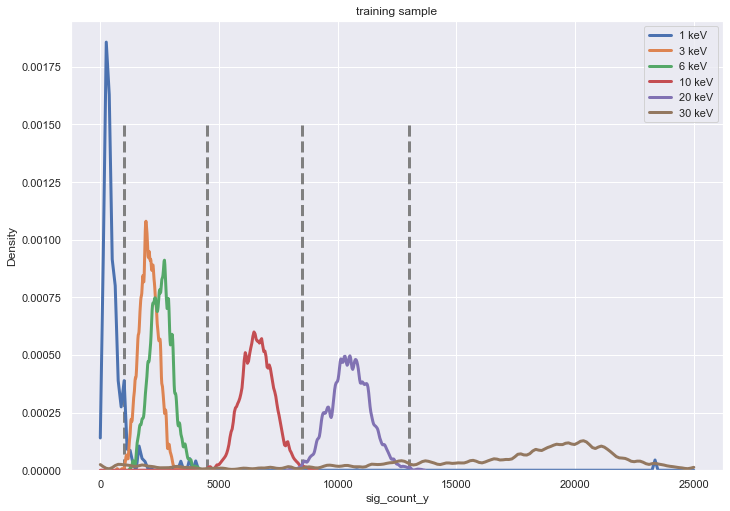

In [16]:
sns.kdeplot(df.query('event_energy == 1').sig_count_y, bw_adjust=0.005*bw_adjust, clip=(0, 25000), linewidth=3, label='1 keV')
sns.kdeplot(df.query('event_energy == 3').sig_count_y, bw_adjust=bw_adjust, clip=(0, 25000), linewidth=3, label='3 keV')
sns.kdeplot(df.query('event_energy == 6').sig_count_y, bw_adjust=bw_adjust, clip=(0, 25000), linewidth=3, label='6 keV')
sns.kdeplot(df.query('event_energy == 10').sig_count_y, bw_adjust=bw_adjust, clip=(0, 25000), linewidth=3, label='10 keV')
sns.kdeplot(df.query('event_energy == 20').sig_count_y, bw_adjust=bw_adjust, clip=(0, 25000), linewidth=3, label='20 keV')
sns.kdeplot(df.query('event_energy == 30').sig_count_y, bw_adjust=0.01*bw_adjust, clip=(0, 25000), linewidth=3, label='30 keV')
plt.vlines([1000, 4500, 8500, 13000], 0, 0.0015, 'grey', linestyles='dashed', linewidth=3)
plt.legend()
plt.title("training sample")
plt.show()

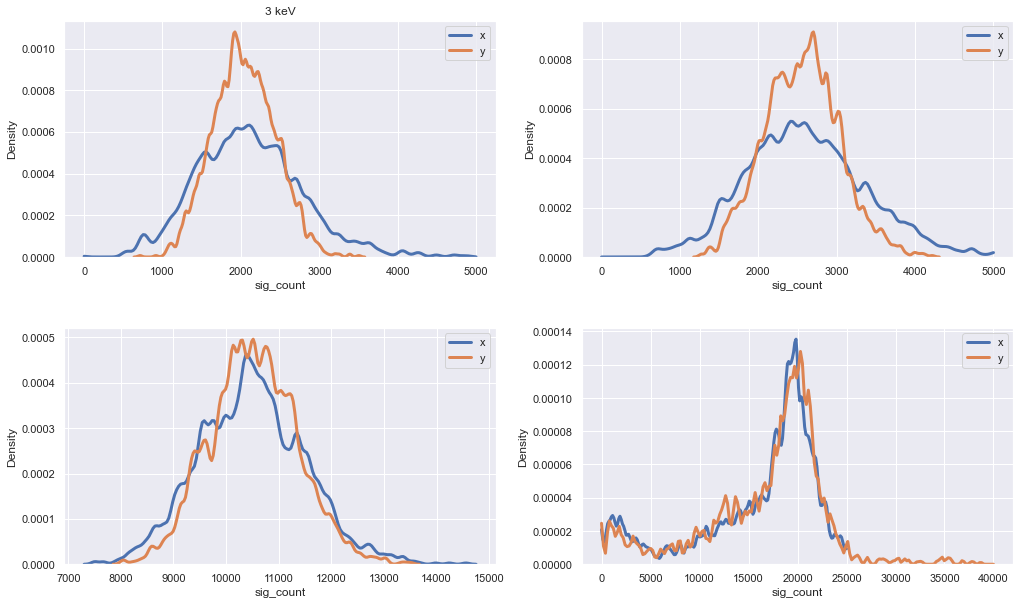

In [17]:
f, axes = plt.subplots(2, 2, figsize=(17,10))
f.subplots_adjust(hspace=0.3)
sns.kdeplot(df.query('event_energy == 3').sig_count_x, bw_adjust=bw_adjust, clip=(0, 5000), linewidth=3, label='x', ax=axes[0,0])
sns.kdeplot(df.query('event_energy == 3').sig_count_y, bw_adjust=bw_adjust, clip=(0, 5000), linewidth=3, label='y', ax=axes[0,0])
axes[0,0].set_title('3 keV'); axes[0,0].set_xlabel('sig_count'); axes[0,0].legend()
#
sns.kdeplot(df.query('event_energy == 6').sig_count_x, bw_adjust=bw_adjust, clip=(0, 5000), linewidth=3, label='x', ax=axes[0,1])
sns.kdeplot(df.query('event_energy == 6').sig_count_y, bw_adjust=bw_adjust, clip=(0, 5000), linewidth=3, label='y', ax=axes[0,1])
axes[0,1].set_xlabel('sig_count'); axes[0,1].legend()
#
sns.kdeplot(df.query('event_energy == 20').sig_count_x, bw_adjust=bw_adjust, clip=(0, 25000), linewidth=3, label='x', ax=axes[1,0])
sns.kdeplot(df.query('event_energy == 20').sig_count_y, bw_adjust=bw_adjust, clip=(0, 25000), linewidth=3, label='y', ax=axes[1,0])
axes[1,0].set_xlabel('sig_count'); axes[1,0].legend()
#
sns.kdeplot(df.query('event_energy == 30').sig_count_x, bw_adjust=0.01*bw_adjust, clip=(0, 25000), linewidth=3, label='x', ax=axes[1,1])
sns.kdeplot(df.query('event_energy == 30').sig_count_y, bw_adjust=0.01*bw_adjust, clip=(0, 40000), linewidth=3, label='y', ax=axes[1,1])
axes[1,1].set_xlabel('sig_count'); axes[1,1].legend()
#
plt.legend()
plt.show()

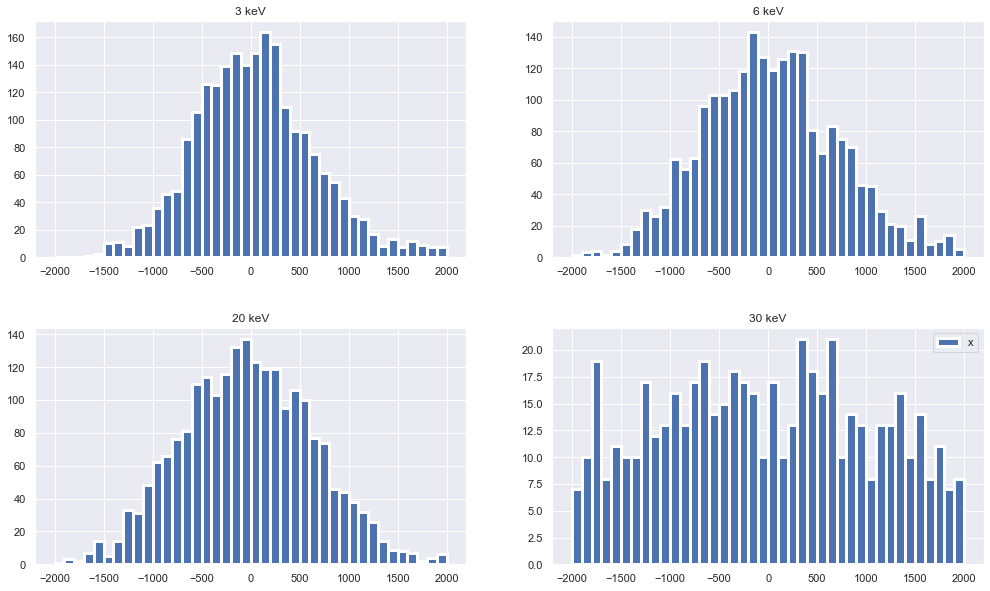

In [18]:
f, axes = plt.subplots(2, 2, figsize=(17,10))
f.subplots_adjust(hspace=0.3)
axes[0,0].hist(df.query('event_energy == 3').sig_count_x - df.query('event_energy == 3').sig_count_y, linewidth=3, label='x', bins=40, range=(-2000, 2000)); axes[0,0].set_title('3 keV'); 
axes[0,1].hist(df.query('event_energy == 6').sig_count_x - df.query('event_energy == 6').sig_count_y, linewidth=3, label='x', bins=40, range=(-2000, 2000)); axes[0,1].set_title('6 keV')
axes[1,0].hist(df.query('event_energy == 20').sig_count_x - df.query('event_energy == 20').sig_count_y, linewidth=3, label='x', bins=40, range=(-2000, 2000)); axes[1,0].set_title('20 keV')
axes[1,1].hist(df.query('event_energy == 30').sig_count_x - df.query('event_energy == 30').sig_count_y, linewidth=3, label='x', bins=40, range=(-2000, 2000)); axes[1,1].set_title('30 keV')
plt.legend()
plt.show()

### importanto

На графике выше при селективном подходе, мысль о котором возникла в чате (комбинация ... vs all + каты), я забыл про разные домены в трейне и тесте. Методика будет работать, если есть тождественность между ER<->NR по распределениям энергии. Это не так для энергии в 30 кэВ, где при замене ER<->NR качественно меняется поведение частицы данной энергии + аналогично для энергии 20 кэВ (но мб вероятность отлёта электрона становится меньше и события становятся чуть больше похожи на NR). Для энергии в 1кэВ я бы ожидал инвариантности (что там, что там ничего не видно среди плоского фона). В промежуточных энергиях есть ощущение, что пики и форма инвариантны при замене типа события, мб с небольшим сдвигом положения (см выше графики sig_count/E (E)). Мб попробовать вслепую потюнить пороги катов относительно трейновских и посмотреть как меняется скор на паблике

Итого, можно попробовать вот так (перебираются классы событий, ожидаемые в тесте): 
* 30 NR: детектить катом по sig_count, каким-то образом оценив положение пика и форму из 30 ER (например, взяв те 2.5 сэмпла из трейна или же глазами разметив парочку ярких событий в паблике😏)
* 20 ER: детектить через классификатор wiggly vs all. Можно потренить на 30 ER, выбрав фичи инвариантные к энергии (e.g. p-value фита)
* 10 NR: детектить катом по sig_count (см картинку серые линии). Здесь предполагаем инвариантость формы при ER<->NR замене (то есть что пик не съедет и не станет шире) - надо чекать
* 3 NR, 6 ER: хз, они перекрываются по энергии, поэтому мб натренить классификатор 3 vs 6 (тоже предположив инвариантность при замене доменов ER<->NR)
* 1 ER: хз, мб катом тоже порезать, или натренить классификатор "ничего не видно vs что-то видно"

### searching for wiggly

In [19]:
np.unique(df.event_energy, return_counts=True)

(array([ 1,  3,  6, 10, 20, 30]), array([2179, 2245, 2256, 2274, 2210, 2239]))

In [20]:
df.columns

Index(['N_bkgr_only_x', 'N_bkgr_only_y', 'N_error_bkgr_only_x',
       'N_error_bkgr_only_y', 'N_error_x', 'N_error_y', 'N_x', 'N_y',
       'bkgr_count_x', 'bkgr_count_y',
       ...
       'tolerance_bkgr_only_x', 'tolerance_bkgr_only_y', 'tolerance_x',
       'tolerance_y', 'up_bkgr_only_x', 'up_bkgr_only_y', 'up_x', 'up_y',
       'sig_count_x_over_E', 'sig_count_y_over_E'],
      dtype='object', length=118)

In [21]:
wiggly_vars = [
              'chi2_pvalue_x', 'chi2_pvalue_y', 
#                'chi2_x', 'chi2_y',
              'dfr', 
              'dmu', 'dsigma', 
              'sigma_x', 'sigma_y', 
#                'sigma_error_x', 'sigma_error_y', 
              'mu_x', 'mu_y', 
#                'mu_error_x', 'mu_error_y', 
       'n_excess_bins_x', 'n_excess_bins_y', 
#                'nfcn_total_x', 'nfcn_total_y',
#        'nfcn_x', 'nfcn_y', 'ngrad_total_x', 'ngrad_total_y', 'ngrad_x', 'ngrad_y', 
#                'sig_count_x', 'sig_count_y', 
#        'sig_density_x', 'sig_density_y', 
#                'dsig_count'
              ]

In [22]:
df_1 = df[df['event_energy'] == 1][:500]
df_3 = df[df['event_energy'] == 3][:500]
df_6 = df[df['event_energy'] == 6][:500]
df_10 = df[df['event_energy'] == 10][:500]
df_20 = df[df['event_energy'] == 20][:500]
df_20 = df_20.query('event_class != "ER"')
df_30 = df[df['event_energy'] == 30]
df_30 = df_30.query('event_class != "NR"')
df_w_vs_all = pd.concat([df_1,df_3,df_6,df_10,df_20,df_30])

In [23]:
# df_w_vs_all['sig_count_y_gr_8500'] = df_w_vs_all.sig_count_y > 8500
# df_public['sig_count_y_gr_8500'] = df_public.sig_count_y > 8500
# df_private['sig_count_y_gr_8500'] = df_private.sig_count_y > 8500

In [24]:
np.unique(df_w_vs_all.event_energy, return_counts=1)

(array([ 1,  3,  6, 10, 20, 30]), array([ 500,  500,  500,  500,  500, 2237]))

In [25]:
X = df_w_vs_all[wiggly_vars]
y = df_w_vs_all['event_energy'] == 30
np.bincount(y)

array([2500, 2237])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [27]:
lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [28]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'max_depth': 4,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'early_stopping_rounds': 10
}

In [29]:
gbm = lgb.train(
                params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,  # eval training data
                verbose_eval=True,
#                 feature_name=X_train.columns,
#                 categorical_feature=[21]
               )

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's binary_logloss: 0.613332
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's binary_logloss: 0.550658
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's binary_logloss: 0.498006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's binary_logloss: 0.45439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's binary_logloss: 0.416389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's binary_logloss: 0.383691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	valid_0's bi

Found `early_stopping_rounds` in params. Will use it instead of argument


In [30]:
y_train_pred = gbm.predict(X_train)
y_test_pred = gbm.predict(X_test)

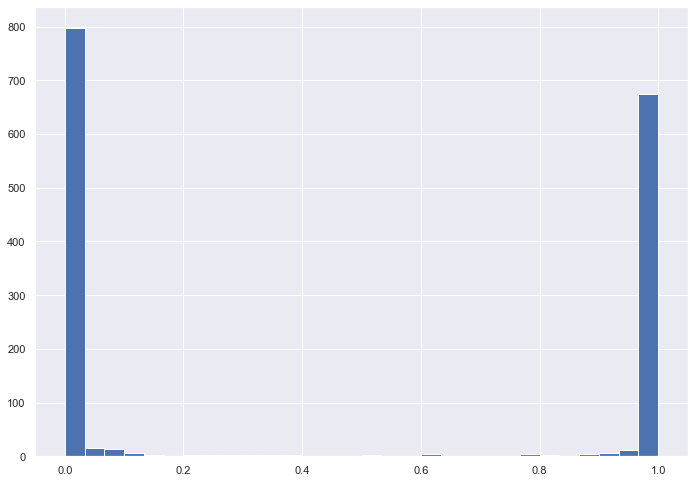

In [31]:
plt.hist(y_test_pred, bins=30)
plt.show()

In [32]:
roc_auc_score(y_train, y_train_pred), roc_auc_score(y_test, y_test_pred)

(1.0, 0.9987155452007724)

In [33]:
thr = 0.5
print(classification_report(y_test, y_test_pred > thr))

              precision    recall  f1-score   support

       False       0.99      0.99      0.99       853
        True       0.99      0.99      0.99       711

    accuracy                           0.99      1564
   macro avg       0.99      0.99      0.99      1564
weighted avg       0.99      0.99      0.99      1564



### test on private samples in train

In [34]:
df_ER[df_ER.event_energy == 20]

,N_bkgr_only_x,N_bkgr_only_y,N_error_bkgr_only_x,N_error_bkgr_only_y,N_error_x,N_error_y,N_x,N_y,bkgr_count_x,bkgr_count_y,...,sigma_x,sigma_y,tolerance_bkgr_only_x,tolerance_bkgr_only_y,tolerance_x,tolerance_y,up_bkgr_only_x,up_bkgr_only_y,up_x,up_y
88,1.459844e+06,1.459781e+06,1208.240082,1208.213869,1208.377341,1208.416193,1.460170e+06,1.460270e+06,1.447035e+06,1.447318e+06,...,8.892997,6.241519,0.1,0.1,0.1,0.1,1.0,1.0,1.0,1.0
1935,1.455492e+06,1.455429e+06,1206.437822,1206.411432,1206.541136,1206.582449,1.455741e+06,1.455841e+06,1.444382e+06,1.445163e+06,...,8.746008,5.217660,0.1,0.1,0.1,0.1,1.0,1.0,1.0,1.0


In [35]:
gbm.predict(df.query('event_energy == 20 and event_class == "ER"')[wiggly_vars])

array([0.99798165, 0.98146324])

### check for various rand seeds

In [36]:
df_1 = df[df['event_energy'] == 1][:500]
df_3 = df[df['event_energy'] == 3][:500]
df_6 = df[df['event_energy'] == 6][:500]
df_10 = df[df['event_energy'] == 10][:500]
df_20 = df[df['event_energy'] == 20][:500]
df_20 = df_20.query('event_class != "ER"')
df_30 = df[df['event_energy'] == 30]
df_30 = df_30.query('event_class != "NR"')
df_w_vs_all = pd.concat([df_1,df_3,df_6,df_10,df_20,df_30])


ER_predict = []
NR_predict = []
evl = []

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'max_depth': 4,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'early_stopping_rounds': 10
}

wiggly_vars = [
              'chi2_pvalue_x', 'chi2_pvalue_y', 
#                'chi2_x', 'chi2_y',
              'dfr', 
              'dmu', 'dsigma', 
              'sigma_x', 'sigma_y', 
#                'sigma_error_x', 'sigma_error_y', 
              'mu_x', 'mu_y', 
#                'mu_error_x', 'mu_error_y', 
       'n_excess_bins_x', 'n_excess_bins_y', 
#                'nfcn_total_x', 'nfcn_total_y',
#        'nfcn_x', 'nfcn_y', 'ngrad_total_x', 'ngrad_total_y', 'ngrad_x', 'ngrad_y', 
#                'sig_count_x', 'sig_count_y', 
#        'sig_density_x', 'sig_density_y', 
#                'dsig_count'
              ]

X = df_w_vs_all[wiggly_vars]
y = df_w_vs_all['event_energy'] == 30

for rand_seed in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=rand_seed)
    
    lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
#     lgb_train = lgb.Dataset(X, y, free_raw_data=False)
#     lgb_eval = lgb.Dataset(X, y, reference=lgb_train)
    
    clf = lgb.train(
                params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,  # eval training data
                verbose_eval=-1,
#                 feature_name=X_train.columns,
#                 categorical_feature=[21]
               )

    ER_predict.append(clf.predict(df.query('event_energy == 20 and event_class == "ER"')[wiggly_vars]))
    NR_predict.append(clf.predict(df.query('event_energy == 30 and event_class == "NR"')[wiggly_vars]))
    
    y_test_pred = clf.predict(X_test)
    evl.append(roc_auc_score(y_test, y_test_pred))

Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[95]	valid_0's binary_logloss: 0.0376947
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[109]	valid_0's binary_logloss: 0.0307674


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.0576646
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[115]	valid_0's binary_logloss: 0.0290251
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[141]	valid_0's binary_logloss: 0.0274014
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.0381183
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[96]	valid_0's binary_logloss: 0.0307745
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[115]	valid_0's binary_logloss: 0.0228128
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[102]	valid_0's binary_logloss: 0.0468728
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[109]	valid_0's binary_logloss: 0.0269844


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.0256242
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[125]	valid_0's binary_logloss: 0.029945
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[125]	valid_0's binary_logloss: 0.0294404
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[106]	valid_0's binary_logloss: 0.0293487


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[85]	valid_0's binary_logloss: 0.024695
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.0365478
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[137]	valid_0's binary_logloss: 0.0243515
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[131]	valid_0's binary_logloss: 0.0259426
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[125]	valid_0's binary_logloss: 0.0276012
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[130]	valid_0's binary_logloss: 0.0312444
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[105]	valid_0's binary_logloss: 0.0352317


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[99]	valid_0's binary_logloss: 0.0354973
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[107]	valid_0's binary_logloss: 0.0258231


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[112]	valid_0's binary_logloss: 0.0313666
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[110]	valid_0's binary_logloss: 0.0361799
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[94]	valid_0's binary_logloss: 0.0400126
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[115]	valid_0's binary_logloss: 0.0320067
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[109]	valid_0's binary_logloss: 0.0248313
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[130]	valid_0's binary_logloss: 0.0328787
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[133]	valid_0's binary_logloss: 0.022061
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[152]	valid_0's binary_logloss: 0.0280416
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[85]	valid_0's binary_logloss: 0.0432162


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[82]	valid_0's binary_logloss: 0.0291848
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[100]	valid_0's binary_logloss: 0.0270058


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.0336292
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[105]	valid_0's binary_logloss: 0.0271122


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[121]	valid_0's binary_logloss: 0.0299666
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.034137
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[104]	valid_0's binary_logloss: 0.0285131
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[119]	valid_0's binary_logloss: 0.0417249


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.026311
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[131]	valid_0's binary_logloss: 0.0302713


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[101]	valid_0's binary_logloss: 0.0345177
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[138]	valid_0's binary_logloss: 0.0342049


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.0240923
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[95]	valid_0's binary_logloss: 0.037882


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[94]	valid_0's binary_logloss: 0.0375826
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[118]	valid_0's binary_logloss: 0.0325179
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[99]	valid_0's binary_logloss: 0.0290979
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[123]	valid_0's binary_logloss: 0.0345084


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[126]	valid_0's binary_logloss: 0.0261849
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[122]	valid_0's binary_logloss: 0.0166952


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[121]	valid_0's binary_logloss: 0.0331991
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[99]	valid_0's binary_logloss: 0.0293528
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[125]	valid_0's binary_logloss: 0.0262629
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[105]	valid_0's binary_logloss: 0.0384019
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[105]	valid_0's binary_logloss: 0.0371959
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[119]	valid_0's binary_logloss: 0.0284542
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[84]	valid_0's binary_logloss: 0.0321844
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[132]	valid_0's binary_logloss: 0.0369128
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[136]	valid_0's binary_logloss: 0.0371107
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.0358762
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[111]	valid_0's binary_logloss: 0.0294537
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[110]	valid_0's binary_logloss: 0.0351
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[109]	valid_0's binary_logloss: 0.0275915
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[131]	valid_0's binary_logloss: 0.0194895
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[83]	valid_0's binary_logloss: 0.0511269
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[116]	valid_0's binary_logloss: 0.0249421
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[111]	valid_0's binary_logloss: 0.0271628
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[135]	valid_0's binary_logloss: 0.0245392
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[88]	valid_0's binary_logloss: 0.0349644
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[99]	valid_0's binary_logloss: 0.0363801
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[92]	valid_0's binary_logloss: 0.0412233
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[107]	valid_0's binary_logloss: 0.038697
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[101]	valid_0's binary_logloss: 0.0257295
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[117]	valid_0's binary_logloss: 0.0346752
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.0365162
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[118]	valid_0's binary_logloss: 0.0236325
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[93]	valid_0's binary_logloss: 0.0351407


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[117]	valid_0's binary_logloss: 0.0284332
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[81]	valid_0's binary_logloss: 0.0572019
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[122]	valid_0's binary_logloss: 0.0270295
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[147]	valid_0's binary_logloss: 0.017637
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[105]	valid_0's binary_logloss: 0.0361798
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[89]	valid_0's binary_logloss: 0.0327218
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[114]	valid_0's binary_logloss: 0.0316522
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[103]	valid_0's binary_logloss: 0.0366153
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[115]	valid_0's binary_logloss: 0.028333
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[139]	valid_0's binary_logloss: 0.0302311


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.0393891
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[123]	valid_0's binary_logloss: 0.0283471
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[105]	valid_0's binary_logloss: 0.0248653
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[118]	valid_0's binary_logloss: 0.0387092
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[102]	valid_0's binary_logloss: 0.0366769
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.049335
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[155]	valid_0's binary_logloss: 0.0233588
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[148]	valid_0's binary_logloss: 0.0281164
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[109]	valid_0's binary_logloss: 0.0314319
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[115]	valid_0's binary_logloss: 0.0313419
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.0407041


Found `early_stopping_rounds` in params. Will use it instead of argument


(0.0, 1.0)

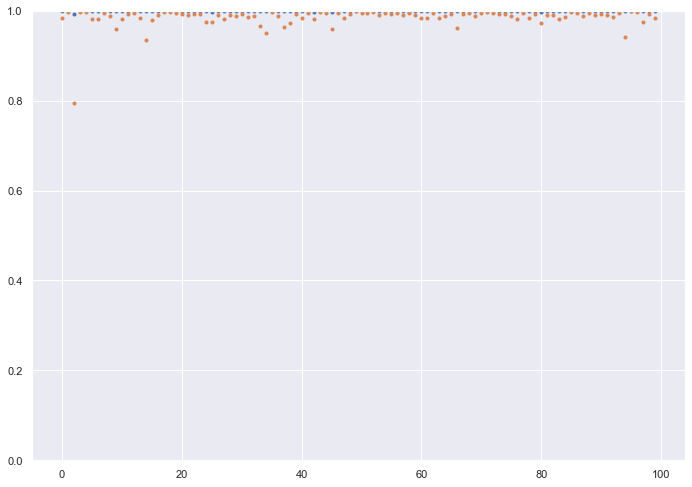

In [37]:
plt.plot(ER_predict, '.')
plt.ylim([0,1])

(0.0, 1.0)

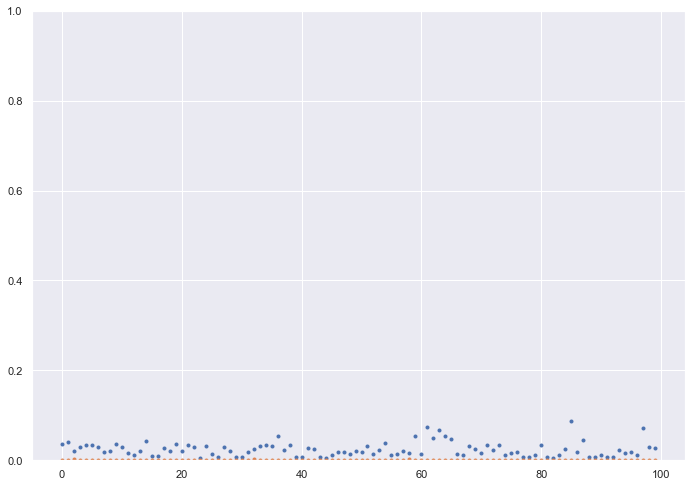

In [38]:
plt.plot(NR_predict, '.')
plt.ylim([0,1])

### test it on public

In [39]:
y_public_pred = gbm.predict(df_public[wiggly_vars])
y_private_pred = gbm.predict(df_private[wiggly_vars])

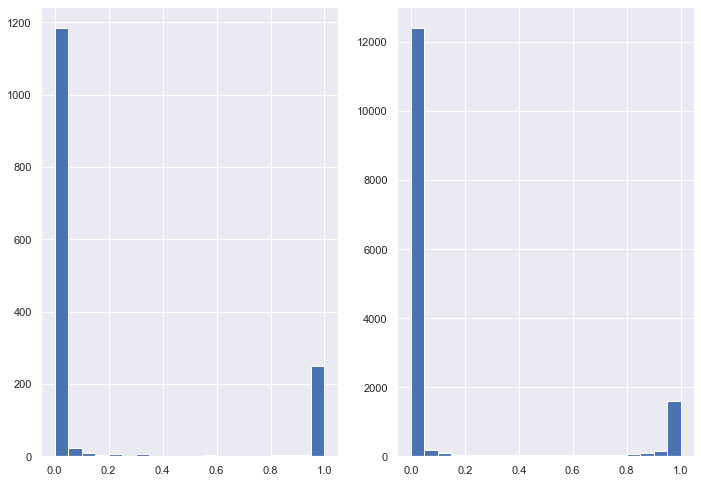

In [40]:
fig, axs = plt.subplots(1, 2)
axs[0].hist(y_public_pred, bins=20)
axs[1].hist(y_private_pred, bins=20)
plt.show()

In [41]:
sum(y_public_pred > 0.5), sum(y_private_pred > 0.5)

(266, 2122)

In [42]:
# thr = 0.5

In [43]:
# public_wiggly_pred = df_public.image_name[y_public_pred > thr].values
# private_wiggly_pred = df_private.image_name[y_private_pred > thr].values

In [44]:
# with open(f'wiggly_public_{thr}.txt', 'w') as f:
#     f.write('\n'.join(public_wiggly_pred))

In [45]:
# with open(f'wiggly_private_{thr}.txt', 'w') as f:
#     f.write('\n'.join(private_wiggly_pred))

### interpret

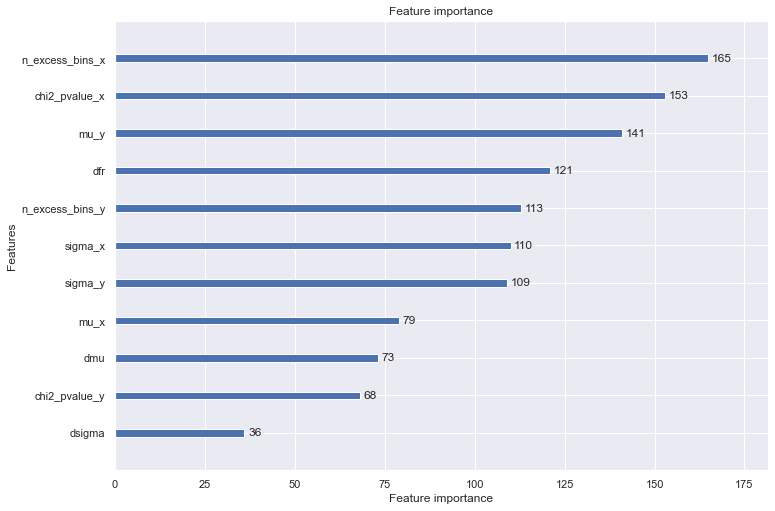

In [46]:
lgb.plot_importance(gbm)
plt.show()

In [47]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(X)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


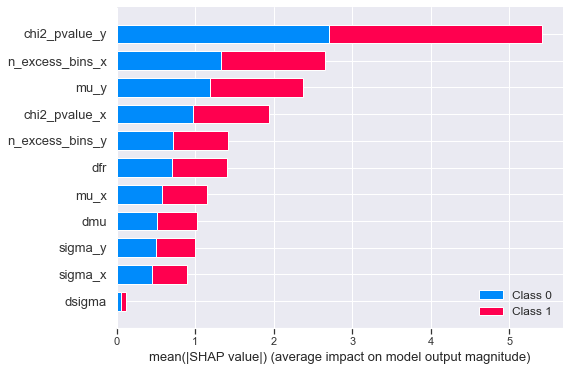

In [48]:
shap.summary_plot(shap_values, X)

### regressor

#### sig_count studies

In [49]:
# is sig_count resolution the same for diff. E?

In [50]:
sc_3_y = df.query('event_energy == 3').sig_count_y
sc_6_y = df.query('event_energy == 6').sig_count_y
sc_10_y = df.query('event_energy == 10').sig_count_y
sc_20_y = df.query('event_energy == 20').sig_count_y
#
sc_3_x = df.query('event_energy == 3').sig_count_x
sc_6_x = df.query('event_energy == 6').sig_count_x
sc_10_x = df.query('event_energy == 10').sig_count_x
sc_20_x = df.query('event_energy == 20').sig_count_x

In [51]:
sc_means = [np.mean(sc_3_y), np.mean(sc_6_y), np.mean(sc_10_y), np.mean(sc_20_y)]
sc_stds = [np.std(sc_3_y), np.std(sc_6_y), np.std(sc_10_y), np.std(sc_20_y)]
sc_energies = [3, 6, 10, 20]

In [52]:
sc_3_y -= np.mean(sc_3_y)
sc_6_y -= np.mean(sc_6_y)
sc_10_y -= np.mean(sc_10_y)
sc_20_y -= np.mean(sc_20_y)
#
sc_3_x -= np.mean(sc_3_x)
sc_6_x -= np.mean(sc_6_x)
sc_10_x -= np.mean(sc_10_x)
sc_20_x -= np.mean(sc_20_x)

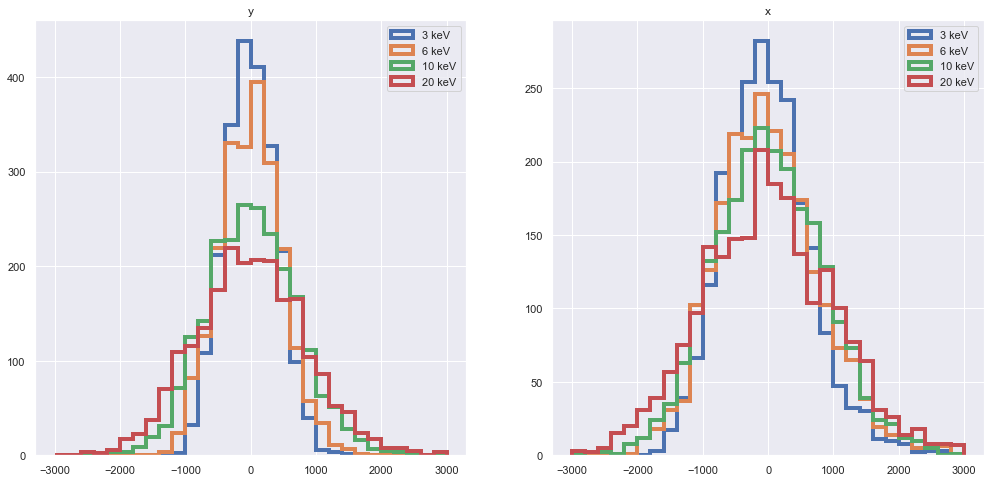

In [53]:
fig, axs = plt.subplots(1,2, figsize=(17,8))
axs[0].hist(sc_3_y, bins=30, histtype='step', linewidth=4, range=(-3000, 3000), label='3 keV')
axs[0].hist(sc_6_y, bins=30, histtype='step', linewidth=4, range=(-3000, 3000), label='6 keV')
axs[0].hist(sc_10_y, bins=30, histtype='step', linewidth=4, range=(-3000, 3000), label='10 keV')
axs[0].hist(sc_20_y, bins=30, histtype='step', linewidth=4, range=(-3000, 3000), label='20 keV')
axs[0].set_title('y')
axs[0].legend()
#
axs[1].hist(sc_3_x, bins=30, histtype='step', linewidth=4, range=(-3000, 3000), label='3 keV')
axs[1].hist(sc_6_x, bins=30, histtype='step', linewidth=4, range=(-3000, 3000), label='6 keV')
axs[1].hist(sc_10_x, bins=30, histtype='step', linewidth=4, range=(-3000, 3000), label='10 keV')
axs[1].hist(sc_20_x, bins=30, histtype='step', linewidth=4, range=(-3000, 3000), label='20 keV')
axs[1].set_title('x')
axs[1].legend()
plt.show()

#### extrapolate mean and std

In [54]:
a_mean, b_mean = np.polyfit(sc_energies, sc_means, deg=1)
a_std, b_std = np.polyfit(sc_energies, sc_stds, deg=1)

In [55]:
mean_30, std_30 = a_mean*30+b_mean, a_std*30+b_std, 
mean_30, std_30 

(16017.213016092774, 1145.5906357630995)

In [56]:
# generate synthetic data
sc_30_synth = np.random.normal(loc=mean_30, scale=std_30, size=2000)

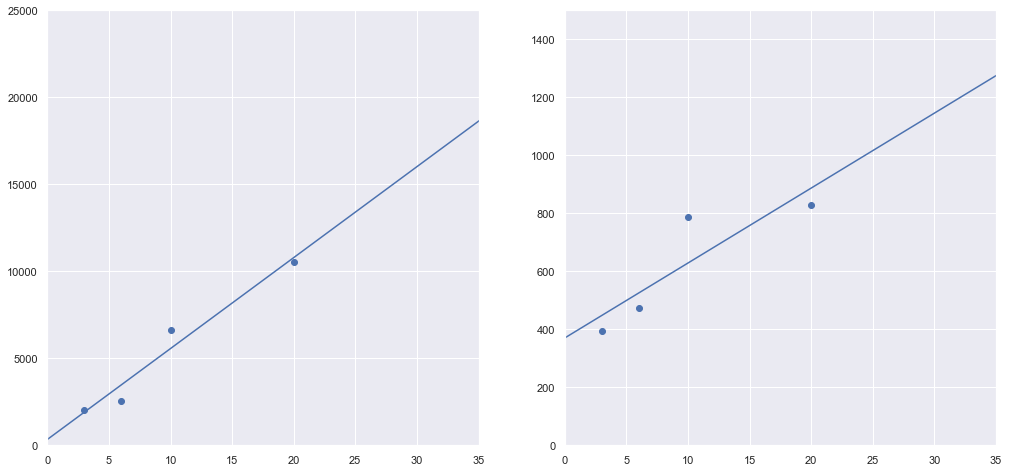

In [57]:
fig, axs = plt.subplots(1,2, figsize=(17,8))
axs[0].scatter(sc_energies, sc_means)
axs[0].plot([0, 40], a_mean*np.array([0, 40])+b_mean)
axs[1].scatter(sc_energies, sc_stds)
axs[1].plot([0, 40], a_std*np.array([0, 40])+b_std)
axs[0].set_xlim(0, 35)
axs[1].set_xlim(0, 35)
axs[0].set_ylim(0, 25000)
axs[1].set_ylim(0, 1500)
plt.show()

#### fit inclusively 

In [58]:
X = df.query('event_energy > 1 and event_energy < 30').sig_count_y
y = df.query('event_energy > 1 and event_energy < 30').event_energy

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# X_train = X_train.values.reshape(-1, 1)
# X_test = X_test.values.reshape(-1, 1)
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

In [60]:
regr = SGDRegressor(loss='squared_loss', penalty='l2', alpha=.01, 
                    max_iter=1000, early_stopping=True, validation_fraction=0.1, n_iter_no_change=10)

In [61]:
# regr.fit(X_train, y_train)
regr.fit(y_train, X_train)

SGDRegressor(alpha=0.01, early_stopping=True, n_iter_no_change=10)

(array([735., 740.,   0.,   0., 755.,   0.,   0.,   0.,   0., 736.]),
 array([ 1945.26000516,  2861.91493534,  3778.56986552,  4695.2247957 ,
         5611.87972588,  6528.53465606,  7445.18958624,  8361.84451642,
         9278.4994466 , 10195.15437678, 11111.80930696]),
 <BarContainer object of 10 artists>)

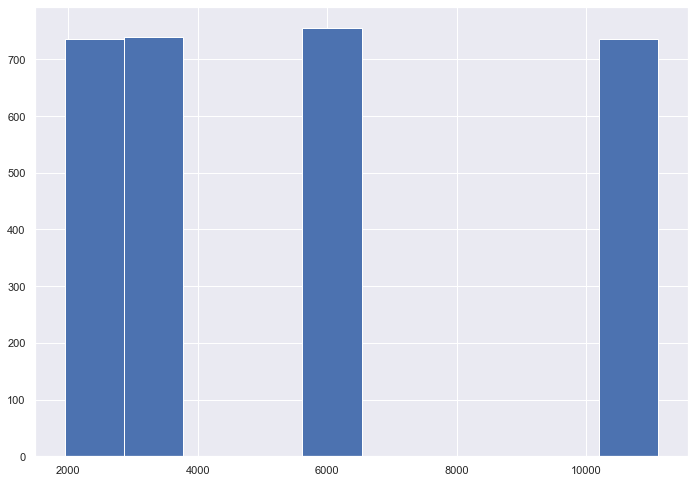

In [62]:
plt.hist(regr.predict(y_test))

In [63]:
a_incl, b_incl = regr.coef_, regr.intercept_
a_incl, b_incl

(array([539.20878246]), array([327.63365778]))

sc = coef_*E + intercept_   
E = (sc - intercept_)/coef_

In [64]:
sc = df.query('event_energy < 30').sig_count_y
E_true = df.query('event_energy < 30').event_energy

In [65]:
E_pred = invert_regr(a_incl, b_incl, sc)
E_pred_30_synth = invert_regr(a_incl, b_incl, sc_30_synth)

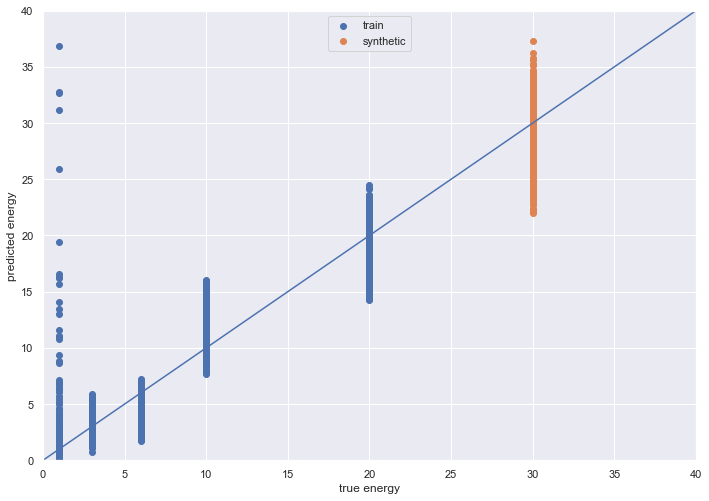

In [66]:
xmin, xmax = 0, 40
plt.scatter(E_true, E_pred, label='train')
plt.scatter(30*np.ones_like(E_pred_30_synth), E_pred_30_synth, label='synthetic')
plt.plot([xmin,xmax], [xmin,xmax])
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)
plt.xlabel('true energy')
plt.ylabel('predicted energy')
plt.legend(loc='upper center')
plt.show()

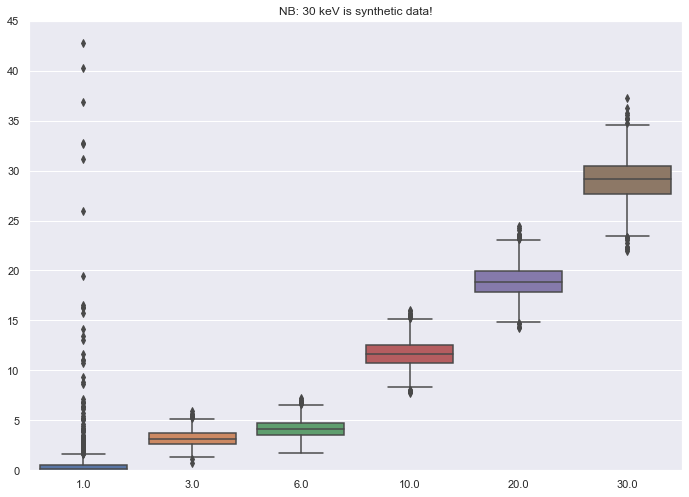

In [67]:
plt.ylim(0, 45)
plt.title("NB: 30 keV is synthetic data!")
sns.boxplot(x=np.concatenate([E_true, 30*np.ones_like(E_pred_30_synth),]), y=np.concatenate([E_pred, E_pred_30_synth]))
plt.show()

#### fit exclusively for ER/NR

In [68]:
cut_ER = f'event_energy>=1 and event_class == "ER" and (event_energy<=20)'
X_ER = df.query(cut_ER).sig_count_y
y_ER = df.query(cut_ER).event_energy
a_ER, b_ER = np.polyfit(y_ER, X_ER, deg=1)

In [69]:
a_ER, b_ER

(651.5889677913029, 89.96106029386895)

In [70]:
a_ER*6+b_ER

3999.4948670416866

In [71]:
cut_NR = 'event_energy>=3 and event_energy<=30 and event_class == "NR"'
X_NR = df.query(cut_NR).sig_count_y
y_NR = df.query(cut_NR).event_energy
X_NR = np.concatenate([X_NR, int(1e5)*[0]])
y_NR = np.concatenate([y_NR, int(1e5)*[1]])
a_NR, b_NR = np.polyfit(y_NR, X_NR, deg=1)

In [72]:
a_NR, b_NR

(551.0121197990459, -554.2402403396411)

In [73]:
a_NR*10+b_NR

4955.880957650817

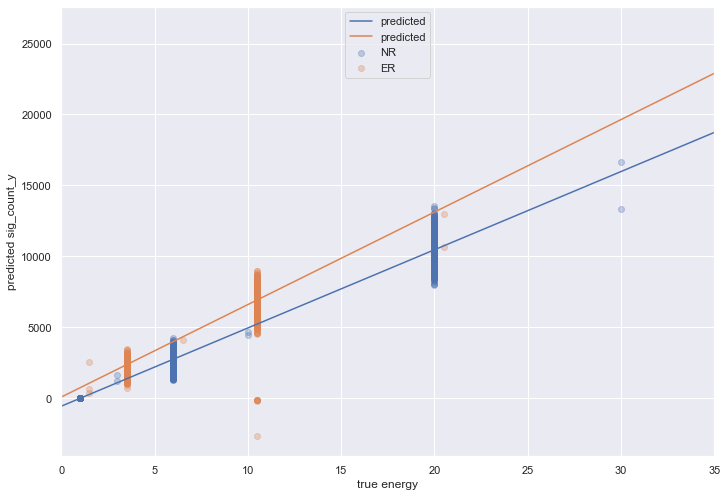

In [74]:
xmin, xmax = 0, 40
plt.scatter(y_NR, X_NR, label='NR', alpha=0.3)
plt.plot([0, 40], a_NR*np.array([0, 40])+b_NR, label='predicted')
plt.xlim(0, 35)
# plt.ylim(-1000, 40000)
plt.xlabel('true energy')
plt.ylabel('predicted sig_count_y')
plt.legend(loc='upper center')

plt.scatter(y_ER + 0.5*np.ones_like(y_ER), X_ER, label='ER', alpha=0.3)
plt.plot([0, 40], a_ER*np.array([0, 40])+b_ER, label='predicted')
# plt.scatter(30*np.ones_like(E_pred_30_synth), E_pred_30_synth, label='synthetic')
# plt.plot([xmin,xmax], [xmin,xmax])
plt.xlabel('true energy')
plt.ylabel('predicted sig_count_y')
plt.legend(loc='upper center')

plt.show()

### hacking private

In [75]:
sc_private = df_private.sig_count_y
E_pred_private = invert_regr(a_NR, b_NR, sc_private)
min(E_pred_private), max(E_pred_private)

(-136.35049928046945, 908.6566936223215)

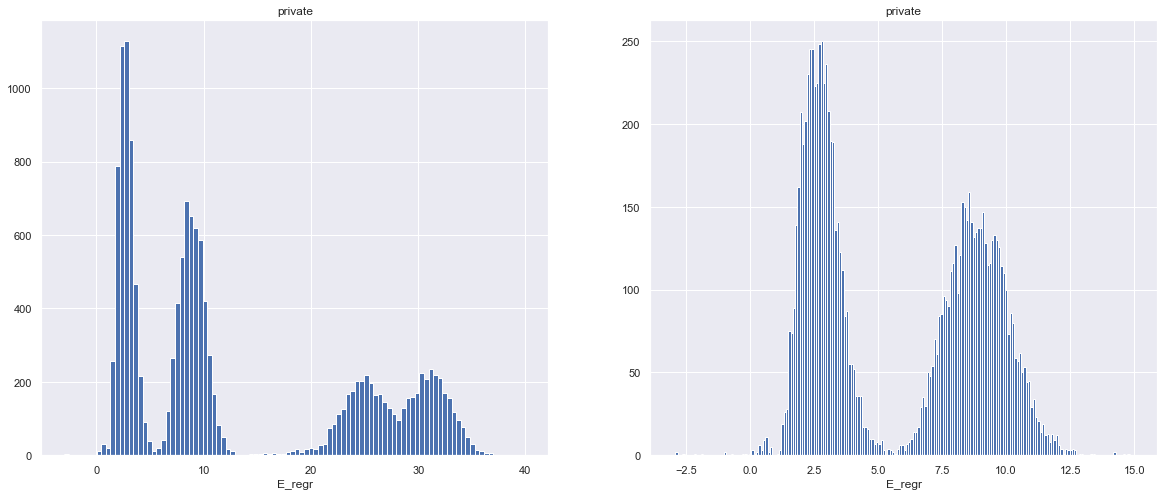

In [76]:
fig, axs = plt.subplots(1, 2, figsize=(20,8))
axs[0].hist(E_pred_private, bins=100, range=(-3, 40))
axs[0].set_xlabel('E_regr')
axs[0].set_title('private')
axs[1].hist(E_pred_private, bins=200, range=(-3, 15))
axs[1].set_xlabel('E_regr')
axs[1].set_title('private')
plt.show()

In [77]:
sum(~((E_pred_private > 0) & (E_pred_private < 50))), E_pred_private.shape

(40, (15058,))

In [78]:
sum(((E_pred_private > 4) & (E_pred_private < 12)))

5219

In [79]:
sum(E_pred_private < 4)

4783

In [80]:
sum((E_pred_private > 26) & (E_pred_private < 40))

3187

In [81]:
sum(E_pred_private < 0)

30

#### remove wiggly

In [82]:
y_private_pred = gbm.predict(df_private[wiggly_vars])

In [83]:
thr = 0.05
sc_private_nw = df_private[y_private_pred<thr].sig_count_y
sc_private_w = df_private[y_private_pred>=thr].sig_count_y
E_pred_private_nw = invert_regr(a_NR, b_NR, sc_private_nw)
E_pred_private_w = invert_regr(a_NR, b_NR, sc_private_w)
min(E_pred_private_nw), max(E_pred_private_nw)

(-2.863391675997106, 37.409968402347005)

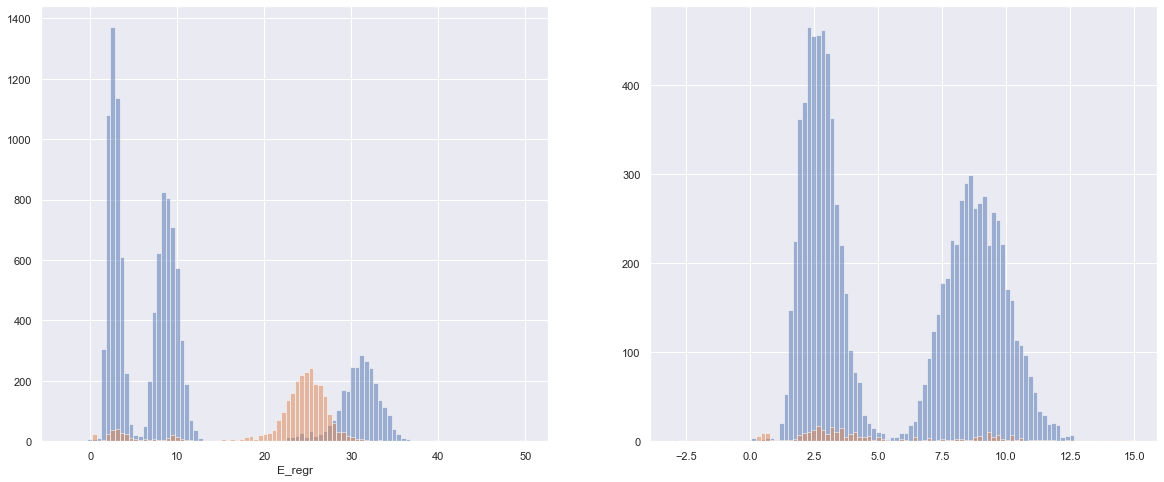

In [84]:
fig, axs = plt.subplots(1, 2, figsize=(20,8))
axs[0].hist(E_pred_private_nw, bins=100, range=(-3, 50), alpha=0.5)
axs[0].hist(E_pred_private_w, bins=100, range=(-3, 50), alpha=0.5)
axs[0].set_xlabel('E_regr')
axs[1].hist(E_pred_private_nw, bins=100, range=(-3, 15), alpha=0.5)
axs[1].hist(E_pred_private_w, bins=100, range=(-3, 15), alpha=0.5)
axs[0].set_xlabel('E_regr')
plt.show()

In [85]:
sum(y_private_pred > 0.05)

2664

### domain difference

In [86]:
sc_train_1 = df.query('event_energy==1').sig_count_y
sc_train_3 = df.query('event_energy==3').sig_count_y
sc_train_6 = df.query('event_energy==6').sig_count_y
sc_train_10 = df.query('event_energy==10').sig_count_y
sc_train_20 = df.query('event_energy==20').sig_count_y
sc_train_30 = df.query('event_energy==30').sig_count_y
E_pred_train_1 = invert_regr(a_NR, b_NR, sc_train_1)
E_pred_train_3 = invert_regr(a_NR, b_NR, sc_train_3)
E_pred_train_6 = invert_regr(a_NR, b_NR, sc_train_6)
E_pred_train_10 = invert_regr(a_NR, b_NR, sc_train_10)
E_pred_train_20 = invert_regr(a_NR, b_NR, sc_train_20)
E_pred_train_30 = invert_regr(a_NR, b_NR, sc_train_30)

In [87]:
sc_train_1_3 = df.query('event_energy>=1 and event_energy<=3').sig_count_y
sc_train_6_10 = df.query('event_energy>=6 and event_energy<=10').sig_count_y
sc_train_20_30 = df.query('event_energy>=20 and event_energy<=30').sig_count_y
E_pred_train_1_3 = invert_regr(a_NR, b_NR, sc_train_1_3)
E_pred_train_6_10 = invert_regr(a_NR, b_NR, sc_train_6_10)
E_pred_train_20_30 = invert_regr(a_NR, b_NR, sc_train_20_30)
E_pred_public = invert_regr(a_NR, b_NR, df_public.sig_count_y)
E_pred_private = invert_regr(a_NR, b_NR, df_private.sig_count_y)
min(E_pred_train_1_3), max(E_pred_train_1_3)

(-407.8003965405331, 246.35546571187686)

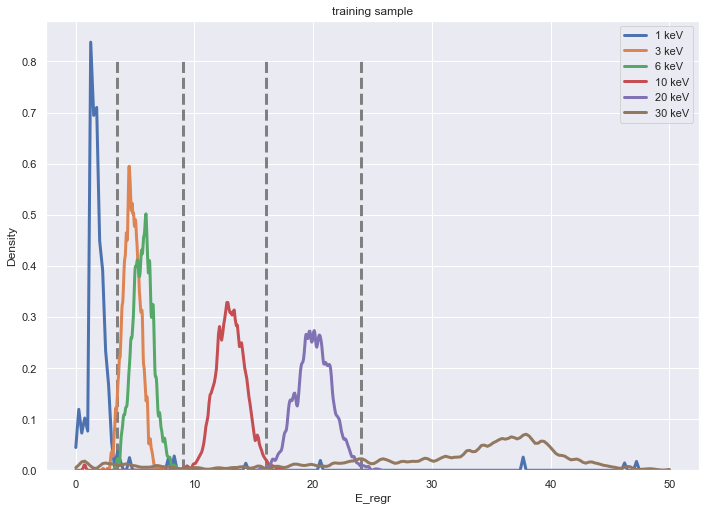

In [88]:
sns.kdeplot(E_pred_train_1, bw_adjust=0.005*bw_adjust, clip=(0, 50), linewidth=3, label='1 keV')
sns.kdeplot(E_pred_train_3, bw_adjust=bw_adjust, clip=(0, 50), linewidth=3, label='3 keV')
sns.kdeplot(E_pred_train_6, bw_adjust=bw_adjust, clip=(0, 50), linewidth=3, label='6 keV')
sns.kdeplot(E_pred_train_10, bw_adjust=bw_adjust, clip=(0, 50), linewidth=3, label='10 keV')
sns.kdeplot(E_pred_train_20, bw_adjust=bw_adjust, clip=(0, 50), linewidth=3, label='20 keV')
sns.kdeplot(E_pred_train_30, bw_adjust=0.01*bw_adjust, clip=(0, 50), linewidth=3, label='30 keV')
plt.vlines([3.5, 9, 16, 24], 0, 0.8, 'grey', linestyles='dashed', linewidth=3)
plt.xlabel("E_regr")
plt.legend()
plt.title("training sample")
plt.show()

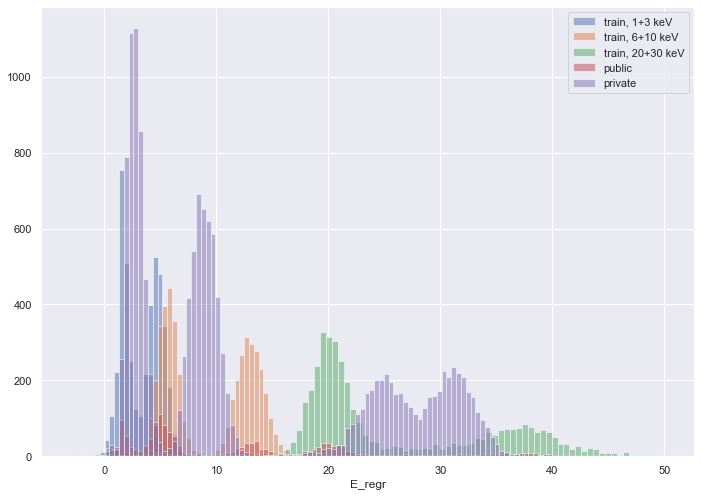

In [89]:
# fig, axs = plt.subplots(1, 2, figsize=(20,8))
plt.hist(E_pred_train_1_3, bins=100, range=(-3, 40), alpha=0.5, label='train, 1+3 keV')
plt.hist(E_pred_train_6_10, bins=100, range=(-3, 40), alpha=0.5, label='train, 6+10 keV')
plt.hist(E_pred_train_20_30, bins=100, range=(-3, 50), alpha=0.5, label='train, 20+30 keV')
plt.hist(E_pred_public, bins=100, range=(-3, 40), alpha=0.5, label='public')
plt.hist(E_pred_private, bins=100, range=(-3, 40), alpha=0.5, label='private')
plt.xlabel('E_regr')
# axs[1].hist(E_pred_private_nw, bins=100, range=(-3, 20), alpha=0.5)
plt.legend()
plt.show()

#### predict on test domain in train

In [90]:
df.query('event_energy == 6 and event_class == "ER"')

,N_bkgr_only_x,N_bkgr_only_y,N_error_bkgr_only_x,N_error_bkgr_only_y,N_error_x,N_error_y,N_x,N_y,bkgr_count_x,bkgr_count_y,...,tolerance_bkgr_only_x,tolerance_bkgr_only_y,tolerance_x,tolerance_y,up_bkgr_only_x,up_bkgr_only_y,up_x,up_y,sig_count_x_over_E,sig_count_y_over_E
2950,1.450287e+06,1.450417e+06,1204.278505,1204.332587,1204.317146,1204.363644,1.450380e+06,1.450492e+06,1.445151e+06,1.446360e+06,...,0.1,0.1,0.1,0.1,1.0,1.0,1.0,1.0,871.449758,688.616644


In [91]:
invert_regr(a_NR, b_NR, df.query('event_energy == 6 and event_class == "ER"').sig_count_y)

2950    8.504241
Name: sig_count_y, dtype: float64

In [92]:
invert_regr(a_NR, b_NR, df.query('event_energy == 10 and event_class == "NR"').sig_count_y)

2586    9.454082
3573    9.125592
Name: sig_count_y, dtype: float64

In [93]:
invert_regr(a_NR, b_NR, df.query('event_energy == 3 and event_class == "NR"').sig_count_y)

5442    4.024427
5684    3.231792
Name: sig_count_y, dtype: float64

In [94]:
invert_regr(a_NR, b_NR, df.query('event_energy == 1 and event_class == "ER"').sig_count_y)

359     2.245204
3691    5.650845
4162    1.657712
Name: sig_count_y, dtype: float64

### separate 6 vs 10 

In [95]:
df.columns

Index(['N_bkgr_only_x', 'N_bkgr_only_y', 'N_error_bkgr_only_x',
       'N_error_bkgr_only_y', 'N_error_x', 'N_error_y', 'N_x', 'N_y',
       'bkgr_count_x', 'bkgr_count_y',
       ...
       'tolerance_bkgr_only_x', 'tolerance_bkgr_only_y', 'tolerance_x',
       'tolerance_y', 'up_bkgr_only_x', 'up_bkgr_only_y', 'up_x', 'up_y',
       'sig_count_x_over_E', 'sig_count_y_over_E'],
      dtype='object', length=118)

In [96]:
clf_vars = [
#               'chi2_pvalue_x', 'chi2_pvalue_y', 
#                'chi2_x', 'chi2_y',
              'dfr', 
              'dmu', 'dsigma', 
#               'fr_error_x', 'fr_error_y', 'fr_x', 'fr_y',
              'sigma_x', 'sigma_y', 
#               'sigma_error_x', 'sigma_error_y', 
              'mu_x', 'mu_y', 
#               'mu_error_x', 'mu_error_y', 
              'n_excess_bins_x', 'n_excess_bins_y', 
#                'nfcn_total_x', 'nfcn_total_y',
#        'nfcn_x', 'nfcn_y', 'ngrad_total_x', 'ngrad_total_y', 'ngrad_x', 'ngrad_y', 
              'sig_count_x', 'sig_count_y', 
              'sig_density_x', 'sig_density_y', 
#                'dsig_count'
              ]

In [97]:
df_10.shape

(500, 118)

In [98]:
# df_1 = df[df['event_energy'] == 1][:500]
# df_3 = df[df['event_energy'] == 3][:500]
df_6 = df[df['event_energy'] == 6]
df_6 = df_6.query('event_class != "ER"')
df_10 = df[df['event_energy'] == 10]
df_10 = df_10.query('event_class != "NR"')
# df_20 = df[df['event_energy'] == 20][:500]
# df_30 = df[df['event_energy'] == 30]
df_6_vs_10 = pd.concat([df_6, df_10])


#df_6_vs_10.sort_values('image_name', inplace=True)

In [99]:
# df_w_vs_all['sig_count_y_gr_8500'] = df_w_vs_all.sig_count_y > 8500
# df_public['sig_count_y_gr_8500'] = df_public.sig_count_y > 8500
# df_private['sig_count_y_gr_8500'] = df_private.sig_count_y > 8500

In [100]:
np.unique(df_6_vs_10.event_energy, return_counts=1)

(array([ 6, 10]), array([2255, 2272]))

In [101]:
X = df_6_vs_10[clf_vars]
y = df_6_vs_10['event_energy'] == 10
np.bincount(y)

array([2255, 2272])

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=15)

In [103]:
lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [104]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'max_depth': 4,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'early_stopping_rounds': 10
}

In [105]:
clf = lgb.train(
                params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,  # eval training data
                verbose_eval=True,
#                 feature_name=X_train.columns,
#                 categorical_feature=[21]
               )

[1]	valid_0's binary_logloss: 0.598721
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.521647
[3]	valid_0's binary_logloss: 0.457102
[4]	valid_0's binary_logloss: 0.402459
[5]	valid_0's binary_logloss: 0.355972
[6]	valid_0's binary_logloss: 0.315764
[7]	valid_0's binary_logloss: 0.280904
[8]	valid_0's binary_logloss: 0.250517
[9]	valid_0's binary_logloss: 0.223907
[10]	valid_0's binary_logloss: 0.200341
[11]	valid_0's binary_logloss: 0.179494
[12]	valid_0's binary_logloss: 0.161011
[13]	valid_0's binary_logloss: 0.144676
[14]	valid_0's binary_logloss: 0.13004
[15]	valid_0's binary_logloss: 0.116972
[16]	valid_0's binary_logloss: 0.105386
[17]	valid_0's binary_logloss: 0.0950425
[18]	valid_0's binary_logloss: 0.0856719
[19]	valid_0's binary_logloss: 0.0774076
[20]	valid_0's binary_logloss: 0.0698933
[21]	valid_0's binary_logloss: 0.0632737
[22]	valid_0's binary_logloss: 0.0572586
[23]	valid_0's binary_logloss: 0.0519008
[24]	valid_0's binary_

Found `early_stopping_rounds` in params. Will use it instead of argument


In [106]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

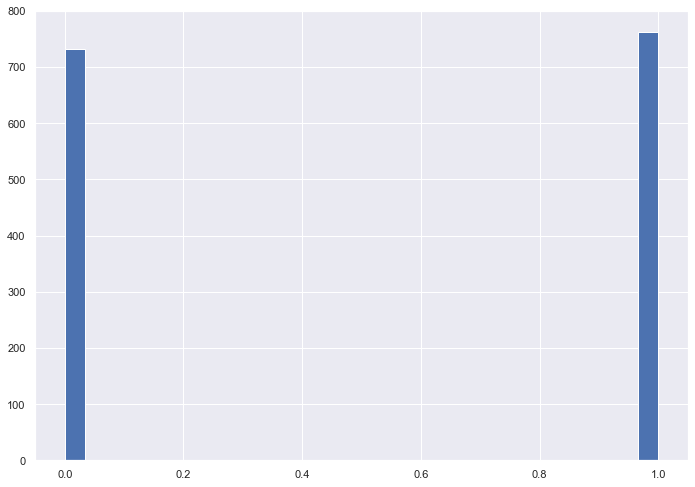

In [107]:
plt.hist(y_test_pred, bins=30)
plt.show()

In [108]:
roc_auc_score(y_train, y_train_pred), roc_auc_score(y_test, y_test_pred)

(1.0, 1.0)

In [109]:
thr = 0.5
print(classification_report(y_test, y_test_pred > thr))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00       732
        True       1.00      1.00      1.00       762

    accuracy                           1.00      1494
   macro avg       1.00      1.00      1.00      1494
weighted avg       1.00      1.00      1.00      1494



In [110]:
clf.predict(df.query('event_energy == 6 and event_class == "ER"')[clf_vars])

array([0.10150211])

In [111]:
clf.predict(df.query('event_energy == 10 and event_class == "NR"')[clf_vars])

array([0.70953011, 0.0414954 ])

In [112]:
df_6 = df[df['event_energy'] == 6]
df_6 = df_6.query('event_class != "ER"')
df_10 = df[df['event_energy'] == 10]
df_10 = df_10.query('event_class != "NR"')
df_6_vs_10 = pd.concat([df_6, df_10])



ER_predict = []
NR_predict = []
evl = []

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'max_depth': 4,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'early_stopping_rounds': 10
}


clf_vars = [
#               'chi2_pvalue_x', 'chi2_pvalue_y', 
#                'chi2_x', 'chi2_y',
              'dfr', 
              'dmu', 'dsigma', 
#               'fr_error_x', 'fr_error_y', 'fr_x', 'fr_y',
              'sigma_x', 'sigma_y', 
#               'sigma_error_x', 'sigma_error_y', 
              'mu_x', 'mu_y', 
#               'mu_error_x', 'mu_error_y', 
              'n_excess_bins_x', 'n_excess_bins_y', 
#                'nfcn_total_x', 'nfcn_total_y',
#        'nfcn_x', 'nfcn_y', 'ngrad_total_x', 'ngrad_total_y', 'ngrad_x', 'ngrad_y', 
              'sig_count_x', 'sig_count_y', 
              'sig_density_x', 'sig_density_y', 
#                'dsig_count'
              ]

X = df_6_vs_10[clf_vars]
y = df_6_vs_10['event_energy'] == 10

for rand_seed in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=rand_seed)
    
    lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
#     lgb_train = lgb.Dataset(X, y, free_raw_data=False)
#     lgb_eval = lgb.Dataset(X, y, reference=lgb_train)
    
    clf = lgb.train(
                params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,  # eval training data
                verbose_eval=-1,
#                 feature_name=X_train.columns,
#                 categorical_feature=[21]
               )

    ER_predict.append(clf.predict(df.query('event_energy == 6 and event_class == "ER"')[clf_vars]))
    NR_predict.append(clf.predict(df.query('event_energy == 10 and event_class == "NR"')[clf_vars]))
    
    y_test_pred = clf.predict(X_test)
    evl.append(roc_auc_score(y_test, y_test_pred))

Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 5.73219e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[176]	valid_0's binary_logloss: 2.56314e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[147]	valid_0's binary_logloss: 8.91457e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[188]	valid_0's binary_logloss: 2.74434e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[172]	valid_0's binary_logloss: 3.68154e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[173]	valid_0's binary_logloss: 2.9947e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[173]	valid_0's binary_logloss: 5.1551e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[177]	valid_0's binary_logloss: 1.77665e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[140]	valid_0's binary_logloss: 5.3437e-06
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[173]	valid_0's binary_logloss: 8.05994e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[175]	valid_0's binary_logloss: 9.64105e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[144]	valid_0's binary_logloss: 3.66946e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[54]	valid_0's binary_logloss: 0.00942028
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[176]	valid_0's binary_logloss: 2.86557e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[185]	valid_0's binary_logloss: 1.71109e-06
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 6.06182e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[203]	valid_0's binary_logloss: 1.62363e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[178]	valid_0's binary_logloss: 6.4492e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[178]	valid_0's binary_logloss: 2.8132e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[74]	valid_0's binary_logloss: 0.0011102
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[174]	valid_0's binary_logloss: 1.86625e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[146]	valid_0's binary_logloss: 7.19956e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.0358707
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[163]	valid_0's binary_logloss: 2.18548e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[163]	valid_0's binary_logloss: 2.17129e-06
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[177]	valid_0's binary_logloss: 1.51839e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[174]	valid_0's binary_logloss: 2.93945e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[196]	valid_0's binary_logloss: 3.25223e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 4.18746e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[155]	valid_0's binary_logloss: 1.85834e-06


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[161]	valid_0's binary_logloss: 3.85062e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[145]	valid_0's binary_logloss: 9.76075e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[172]	valid_0's binary_logloss: 4.95941e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[177]	valid_0's binary_logloss: 5.0636e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[147]	valid_0's binary_logloss: 2.9734e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[149]	valid_0's binary_logloss: 3.58913e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[200]	valid_0's binary_logloss: 2.40397e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[143]	valid_0's binary_logloss: 5.81088e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[146]	valid_0's binary_logloss: 4.38529e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[171]	valid_0's binary_logloss: 2.63745e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.00603789
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 2.13366e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[176]	valid_0's binary_logloss: 3.59947e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[166]	valid_0's binary_logloss: 3.10667e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 2.17159e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[189]	valid_0's binary_logloss: 1.41135e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[146]	valid_0's binary_logloss: 1.06434e-06
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[177]	valid_0's binary_logloss: 3.40682e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[146]	valid_0's binary_logloss: 2.27615e-06
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[193]	valid_0's binary_logloss: 1.57662e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 1.06894e-06
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[179]	valid_0's binary_logloss: 2.071e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[205]	valid_0's binary_logloss: 2.68243e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 2.19386e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[185]	valid_0's binary_logloss: 5.58442e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[178]	valid_0's binary_logloss: 2.94152e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[182]	valid_0's binary_logloss: 3.88326e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[159]	valid_0's binary_logloss: 3.06611e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[189]	valid_0's binary_logloss: 3.3393e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[166]	valid_0's binary_logloss: 3.3266e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[168]	valid_0's binary_logloss: 2.27095e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[169]	valid_0's binary_logloss: 4.87928e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[167]	valid_0's binary_logloss: 2.73778e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.00309597
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[149]	valid_0's binary_logloss: 3.30131e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[159]	valid_0's binary_logloss: 1.60506e-06
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[172]	valid_0's binary_logloss: 2.19919e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[171]	valid_0's binary_logloss: 2.28425e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[187]	valid_0's binary_logloss: 2.99243e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[158]	valid_0's binary_logloss: 2.05766e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[158]	valid_0's binary_logloss: 2.44536e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[166]	valid_0's binary_logloss: 4.61103e-06
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[161]	valid_0's binary_logloss: 2.88537e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[167]	valid_0's binary_logloss: 4.77896e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[152]	valid_0's binary_logloss: 2.49711e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 2.92433e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[139]	valid_0's binary_logloss: 1.32143e-05
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.00374033


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[143]	valid_0's binary_logloss: 4.11288e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[152]	valid_0's binary_logloss: 3.76016e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[172]	valid_0's binary_logloss: 2.15044e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[174]	valid_0's binary_logloss: 1.30729e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[150]	valid_0's binary_logloss: 6.43727e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[186]	valid_0's binary_logloss: 2.10284e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[157]	valid_0's binary_logloss: 5.63548e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[149]	valid_0's binary_logloss: 4.96122e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[141]	valid_0's binary_logloss: 4.05163e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[186]	valid_0's binary_logloss: 2.18939e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 2.30366e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[206]	valid_0's binary_logloss: 2.83483e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[206]	valid_0's binary_logloss: 2.2819e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 8.86849e-05
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[135]	valid_0's binary_logloss: 1.07028e-05
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[152]	valid_0's binary_logloss: 3.49258e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[216]	valid_0's binary_logloss: 1.80369e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[166]	valid_0's binary_logloss: 3.27086e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[194]	valid_0's binary_logloss: 4.55464e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[172]	valid_0's binary_logloss: 5.66856e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[190]	valid_0's binary_logloss: 1.05303e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[151]	valid_0's binary_logloss: 3.54509e-07


In [113]:
sum([ER_predict[i][0]>0.5 for i in range(len(ER_predict))])

49

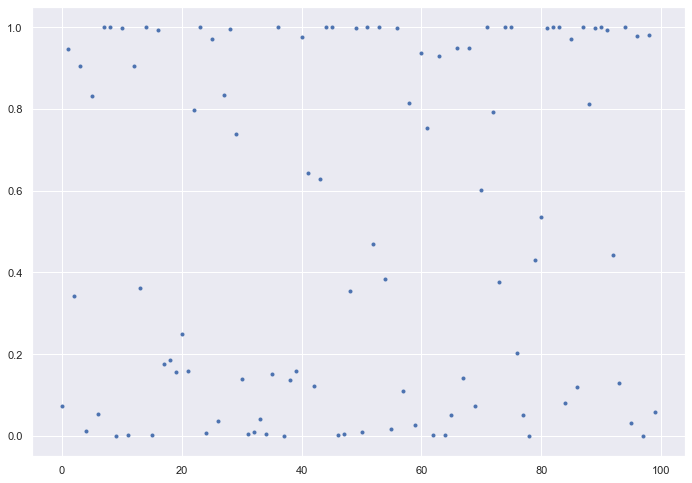

In [114]:
plt.plot(ER_predict, '.')

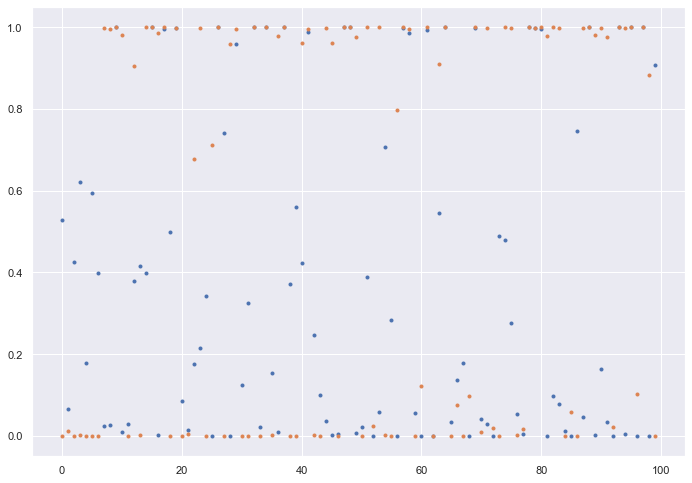

In [115]:
plt.plot(NR_predict, '.')

In [116]:
df_6 = df[df['event_energy'] == 6]
df_10 = df[df['event_energy'] == 10]
df_6_vs_10 = pd.concat([df_6, df_10])

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'max_depth': 4,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'early_stopping_rounds': 10
}

ER_predict = []
NR_predict = []
evl = []

clf_vars_with_name = [
              'dfr', 
              'dmu', 'dsigma', 
              'sigma_x', 'sigma_y', 
              'mu_x', 'mu_y', 
              'n_excess_bins_x', 'n_excess_bins_y', 
              'sig_count_x', 'sig_count_y', 
              'sig_density_x', 'sig_density_y', 
              'image_name'
              ]

clf_vars = list(set(clf_vars_with_name) - set(['image_name']))

X = df_6_vs_10[clf_vars_with_name]
y = df_6_vs_10['event_energy'] == 10

names_of_im = []

for rand_seed in range(100):
    X_train_with_name, X_test_with_name, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=rand_seed)
    X_train, X_test = X_train_with_name.drop(['image_name'], axis=1), X_test_with_name.drop(['image_name'], axis=1)
    lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
#     lgb_train = lgb.Dataset(X, y, free_raw_data=False)
#     lgb_eval = lgb.Dataset(X, y, reference=lgb_train)
    
    clf = lgb.train(
                params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,  # eval training data
                verbose_eval=-1,
#                 feature_name=X_train.columns,
#                 categorical_feature=[21]
               )

    ER_predict.append(clf.predict(df.query('event_energy == 6 and event_class == "ER"')[clf_vars]))
    NR_predict.append(clf.predict(df.query('event_energy == 10 and event_class == "NR"')[clf_vars]))
    
    y_test_pred = clf.predict(X_test)
    evl.append(roc_auc_score(y_test, y_test_pred))
    
    if ER_predict[-1][0] > 1e-3:
        names_of_im.append(X_train_with_name['image_name'])
    if NR_predict[-1][0] < 1 - 1e-3:
        names_of_im.append(X_train_with_name['image_name'])
    if NR_predict[-1][1] < 1 - 1e-3:
        names_of_im.append(X_train_with_name['image_name'])

Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[70]	valid_0's binary_logloss: 0.022573
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.00419496
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 2.03246e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[158]	valid_0's binary_logloss: 6.38516e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[172]	valid_0's binary_logloss: 2.42974e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[193]	valid_0's binary_logloss: 2.43834e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[162]	valid_0's binary_logloss: 1.88618e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[176]	valid_0's binary_logloss: 4.81028e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[190]	valid_0's binary_logloss: 2.22768e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[184]	valid_0's binary_logloss: 2.57227e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.0314116
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[185]	valid_0's binary_logloss: 1.89799e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[169]	valid_0's binary_logloss: 3.26714e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[165]	valid_0's binary_logloss: 8.86859e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[110]	valid_0's binary_logloss: 6.09701e-05
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[186]	valid_0's binary_logloss: 2.08762e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[160]	valid_0's binary_logloss: 1.69211e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[176]	valid_0's binary_logloss: 2.96521e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[200]	valid_0's binary_logloss: 2.4178e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[207]	valid_0's binary_logloss: 1.51667e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[177]	valid_0's binary_logloss: 1.5971e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[185]	valid_0's binary_logloss: 1.69889e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[169]	valid_0's binary_logloss: 3.93786e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[169]	valid_0's binary_logloss: 2.74971e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[171]	valid_0's binary_logloss: 3.98758e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[160]	valid_0's binary_logloss: 1.89795e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[73]	valid_0's binary_logloss: 0.00132558
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[176]	valid_0's binary_logloss: 2.82044e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[85]	valid_0's binary_logloss: 0.00108173
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[177]	valid_0's binary_logloss: 1.99051e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 2.13466e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[175]	valid_0's binary_logloss: 2.31772e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[175]	valid_0's binary_logloss: 2.55242e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[182]	valid_0's binary_logloss: 1.86402e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 3.38507e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[189]	valid_0's binary_logloss: 3.0807e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[218]	valid_0's binary_logloss: 3.9945e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[182]	valid_0's binary_logloss: 3.7814e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[148]	valid_0's binary_logloss: 4.37821e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[206]	valid_0's binary_logloss: 2.29013e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[165]	valid_0's binary_logloss: 3.23082e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[172]	valid_0's binary_logloss: 3.02833e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[173]	valid_0's binary_logloss: 1.95831e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[146]	valid_0's binary_logloss: 5.10054e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[150]	valid_0's binary_logloss: 5.89805e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[185]	valid_0's binary_logloss: 1.8994e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[179]	valid_0's binary_logloss: 4.9506e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[168]	valid_0's binary_logloss: 3.36168e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[198]	valid_0's binary_logloss: 1.57592e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[144]	valid_0's binary_logloss: 4.11316e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[167]	valid_0's binary_logloss: 2.87009e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[176]	valid_0's binary_logloss: 2.74837e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 3.5841e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[152]	valid_0's binary_logloss: 3.09501e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[190]	valid_0's binary_logloss: 3.75138e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[159]	valid_0's binary_logloss: 3.28025e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[179]	valid_0's binary_logloss: 3.30959e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[176]	valid_0's binary_logloss: 6.76064e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 6.74425e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[143]	valid_0's binary_logloss: 1.00085e-06
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[149]	valid_0's binary_logloss: 7.20459e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.0247163
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[190]	valid_0's binary_logloss: 1.86086e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[172]	valid_0's binary_logloss: 1.12582e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[156]	valid_0's binary_logloss: 8.25884e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[176]	valid_0's binary_logloss: 2.8934e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[212]	valid_0's binary_logloss: 2.9685e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[188]	valid_0's binary_logloss: 1.39432e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[159]	valid_0's binary_logloss: 3.38687e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[148]	valid_0's binary_logloss: 8.71889e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[74]	valid_0's binary_logloss: 0.00295861
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[195]	valid_0's binary_logloss: 1.835e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[181]	valid_0's binary_logloss: 3.53135e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[174]	valid_0's binary_logloss: 3.05315e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[193]	valid_0's binary_logloss: 1.10327e-06
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[175]	valid_0's binary_logloss: 2.92847e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[169]	valid_0's binary_logloss: 6.68108e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[162]	valid_0's binary_logloss: 2.32095e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[150]	valid_0's binary_logloss: 9.18622e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[155]	valid_0's binary_logloss: 3.5031e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[163]	valid_0's binary_logloss: 2.71656e-07


Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[191]	valid_0's binary_logloss: 3.06634e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[171]	valid_0's binary_logloss: 3.92633e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[179]	valid_0's binary_logloss: 5.43406e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[168]	valid_0's binary_logloss: 4.37333e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[160]	valid_0's binary_logloss: 1.55143e-07
Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[176]	valid_0's binary_logloss: 2.76355e-06
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[155]	valid_0's binary_logloss: 8.30886e-07


Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[163]	valid_0's binary_logloss: 6.52379e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[178]	valid_0's binary_logloss: 2.2966e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[167]	valid_0's binary_logloss: 3.45118e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[169]	valid_0's binary_logloss: 6.5999e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[207]	valid_0's binary_logloss: 1.05868e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 2.28478e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[175]	valid_0's binary_logloss: 2.89074e-07
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[169]	valid_0's binary_logloss: 9.32268e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[181]	valid_0's binary_logloss: 2.91512e-07


Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[163]	valid_0's binary_logloss: 2.44977e-06
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.0178201
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[185]	valid_0's binary_logloss: 3.1436e-07


Found `early_stopping_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


In [117]:
print('validation roc auc: {:f}+-{:f} '.format(np.mean(evl), np.std(evl)))

validation roc auc: 1.000000+-0.000000 


In [118]:
sum([ER_predict[i][0] > 1e-1 for i in range(len(ER_predict))]) / len(ER_predict)

0.95

In [119]:
sum([NR_predict[i][0] < 1 - 1e-1 for i in range(len(NR_predict))]) / len(NR_predict)

0.19

In [120]:
sum([NR_predict[i][1] < 1 - 1e-1 for i in range(len(NR_predict))]) / len(NR_predict)

0.2

In [121]:
clf.predict(df.query('event_energy == 6 and event_class == "ER"')[clf_vars])

array([0.9948653])

In [122]:
clf.predict(df.query('event_energy == 10 and event_class == "NR"')[clf_vars])

array([0.99693337, 0.9948653 ])

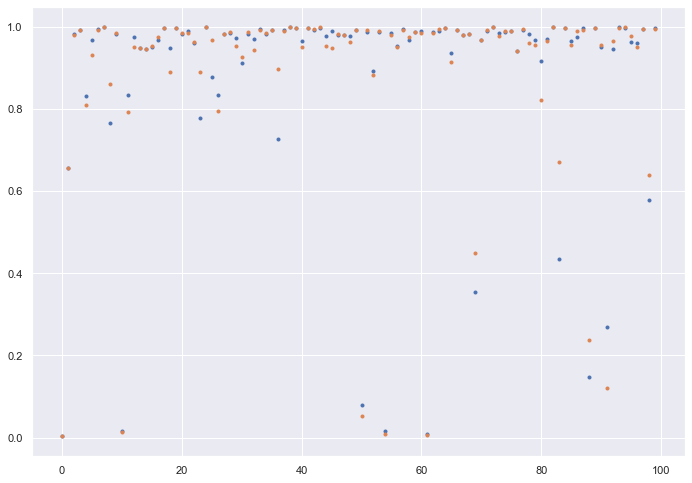

In [123]:
plt.plot(NR_predict, '.')

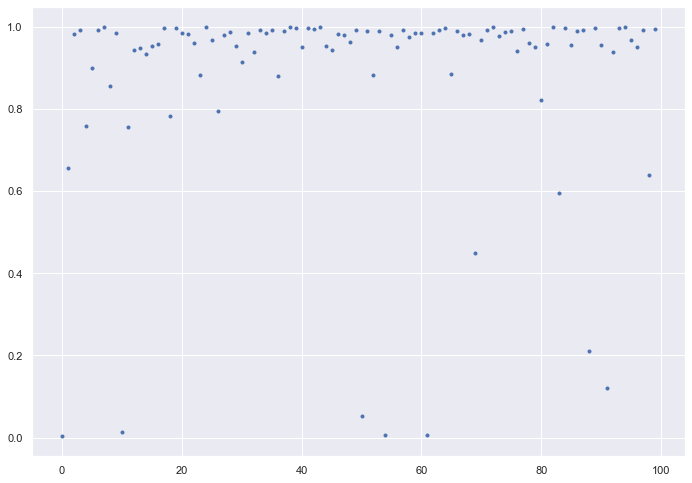

In [124]:
plt.plot(ER_predict, '.')

In [125]:
len(np.array(ER_predict) > 1e-3)

100

In [126]:
ER_predict[i][0] 

NameError: name 'i' is not defined

In [ ]:
plt.plot(NR_predict, '.')

In [ ]:
intersection = names_of_im[0]
for i in range(1,len(names_of_im)):
    intersection = list(set(names_of_im[i]).intersection(intersection))

In [ ]:
len(intersection)

In [ ]:
from utils import *

### 

In [127]:
intersection

NameError: name 'intersection' is not defined

In [128]:
tmp = plot_images('../../idao_dataset/', im_filename=intersection)

NameError: name 'plot_images' is not defined

In [129]:
tmp = plot_images('../../idao_dataset/', class_to_plot='NR', energy_to_plot=6, max_num_images=10, rand_seed=10)

NameError: name 'plot_images' is not defined

In [130]:
tmp = plot_images('../../idao_dataset/', class_to_plot='ER', energy_to_plot=10, max_num_images=10, rand_seed=10)

NameError: name 'plot_images' is not defined

In [131]:
tmp = plot_images('../../idao_dataset/', class_to_plot='ER', energy_to_plot=6, max_num_images=10, rand_seed=10)

NameError: name 'plot_images' is not defined

In [132]:
tmp = plot_images('../../idao_dataset/', class_to_plot='NR', energy_to_plot=10, max_num_images=10, rand_seed=10)

NameError: name 'plot_images' is not defined

In [133]:
df.query('event_energy == 10 and event_class == "NR"')[clf_vars]

,dsigma,sig_count_x,mu_y,sigma_x,sig_count_y,n_excess_bins_y,n_excess_bins_x,sig_density_x,sigma_y,mu_x,sig_density_y,dfr,dmu
2586,-1.797976,3904.511020,288.176635,4.516990,4655.073580,69.0,74.0,864.405486,6.314966,287.439026,737.149408,-0.000517,-0.737608
3573,0.257050,4945.396063,287.670160,5.799134,4474.071746,72.0,70.0,852.781837,5.542084,289.311151,807.290444,0.000325,1.640990


In [134]:
df.query('event_energy == 6 and event_class == "ER"')[clf_vars]

,dsigma,sig_count_x,mu_y,sigma_x,sig_count_y,n_excess_bins_y,n_excess_bins_x,sig_density_x,sigma_y,mu_x,sig_density_y,dfr,dmu
2950,1.08763,5228.698547,289.150199,5.614171,4131.699865,76.0,73.0,931.339372,4.526541,290.983368,912.771956,0.000757,1.833169


In [135]:
np.mean(df.query('event_energy == 10 and event_class == "ER"')[clf_vars]).T

dsigma               -0.049326
sig_count_x        6576.167639
mu_y                287.335397
sigma_x               4.824628
sig_count_y        6608.792570
n_excess_bins_y      72.225792
n_excess_bins_x      70.223592
sig_density_x      1378.240618
sigma_y               4.873954
mu_x                287.182615
sig_density_y      1366.134304
dfr                  -0.000022
dmu                  -0.152783
dtype: float64

In [136]:
np.mean(df.query('event_energy == 6 and event_class == "NR"')[clf_vars]).T

dsigma                0.052693
sig_count_x        2613.825187
mu_y                287.990290
sigma_x               6.010567
sig_count_y        2556.805940
n_excess_bins_y      72.006208
n_excess_bins_x      67.959202
sig_density_x       462.862970
sigma_y               5.957874
mu_x                288.006889
sig_density_y       431.197655
dfr                   0.000040
dmu                   0.016598
dtype: float64

In [137]:
from utils import *

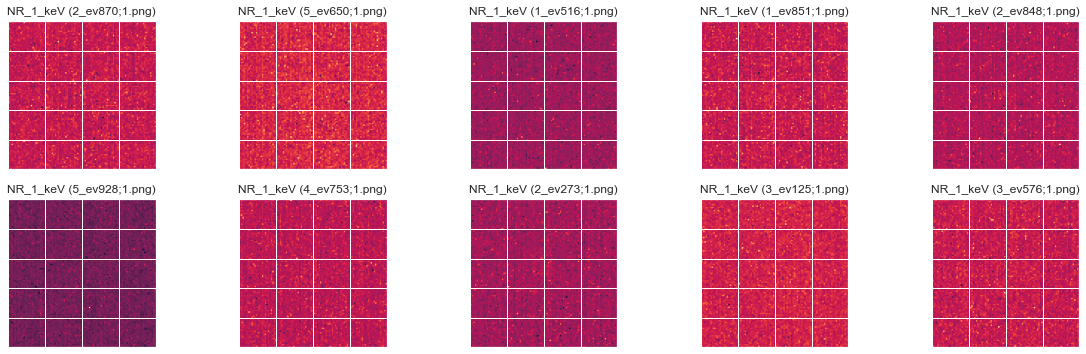

In [138]:
tmp = plot_images('../../idao_dataset/', class_to_plot='NR', energy_to_plot=1, max_num_images=10, rand_seed=10)

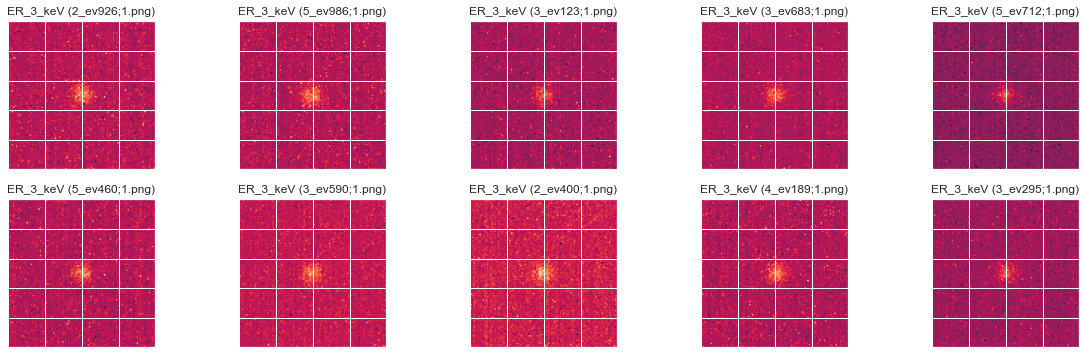

In [139]:
tmp = plot_images('../../idao_dataset/', class_to_plot='ER', energy_to_plot=3, max_num_images=10, rand_seed=10)

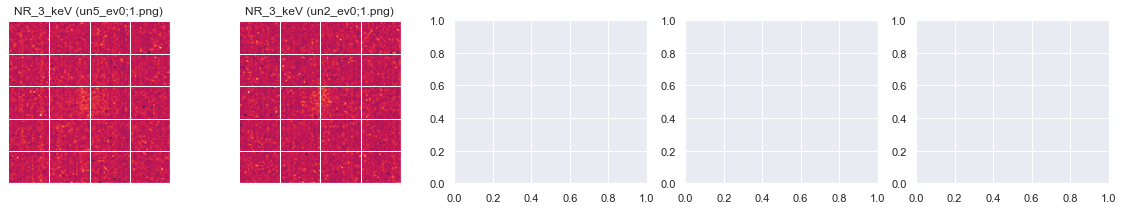

In [140]:
tmp1 = plot_images('../../idao_dataset/', class_to_plot='NR', energy_to_plot=3, max_num_images=10, rand_seed=10)

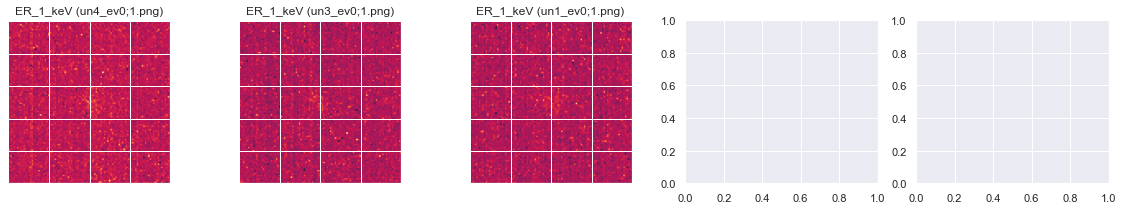

In [141]:
tmp2 = plot_images('../../idao_dataset/', class_to_plot='ER', energy_to_plot=1, max_num_images=10, rand_seed=10)

In [142]:
np.mean(tmp1[1][:,0])

100.79

In [143]:
np.mean(tmp2[2][:,0])

100.6

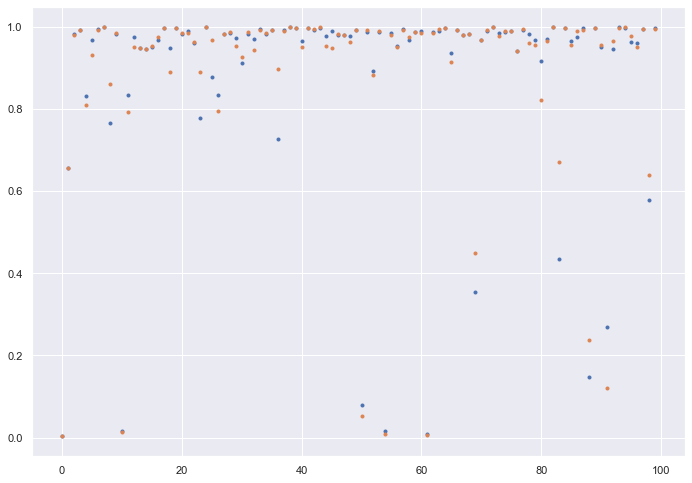

In [144]:
plt.plot(NR_predict, '.')

In [145]:
clf.predict(df.query('event_energy == 6 and event_class == "ER"')[clf_vars])

array([0.9948653])

In [146]:
clf.predict(df.query('event_energy == 10 and event_class == "NR"')[clf_vars])

array([0.99693337, 0.9948653 ])

In [147]:
# from sklearn.model_selection import StratifiedKFold

# kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# roc_auc = []

# i = 0
# for train, test in kfold.split(X, y):
    
#     lgb_train = lgb.Dataset(X.iloc[train], y.iloc[train], free_raw_data=False)
#     lgb_eval = lgb.Dataset(X.iloc[test], y.iloc[test], reference=lgb_train)

#     clf = lgb.train(
#                 params,
#                 lgb_train,
#                 num_boost_round=1000,
#                 valid_sets=lgb_eval,  # eval training data
#                 verbose_eval=True,
#     #                 feature_name=X_train.columns,
#     #                 categorical_feature=[21]
#                )
#     y_test_pred = clf.predict(X.iloc[test])
#     roc_auc.append(roc_auc_score(y.iloc[test], y_test_pred))
#     print("Test set ROC_AUC for {} cycle:{}".format(i+1,roc_auc[i]))
#     i+=1

# print("Mean ROC_AUC for {}-fold cross validation : {}".format(len(roc_auc), np.mean(roc_auc)))

In [148]:
df.query('event_energy == 10 and event_class == "NR"')['image_name']

2586    2.4159998893737793__CYGNO_60_40_He_NR_10_keV_9...
3573    -0.9444000124931335__CYGNO_60_40_He_NR_10_keV_...
Name: image_name, dtype: object

In [149]:
df.query('event_energy == 10 and event_class == "NR"')[clf_vars]

,dsigma,sig_count_x,mu_y,sigma_x,sig_count_y,n_excess_bins_y,n_excess_bins_x,sig_density_x,sigma_y,mu_x,sig_density_y,dfr,dmu
2586,-1.797976,3904.511020,288.176635,4.516990,4655.073580,69.0,74.0,864.405486,6.314966,287.439026,737.149408,-0.000517,-0.737608
3573,0.257050,4945.396063,287.670160,5.799134,4474.071746,72.0,70.0,852.781837,5.542084,289.311151,807.290444,0.000325,1.640990


### dev

<AxesSubplot:xlabel='sig_density_y', ylabel='Count'>

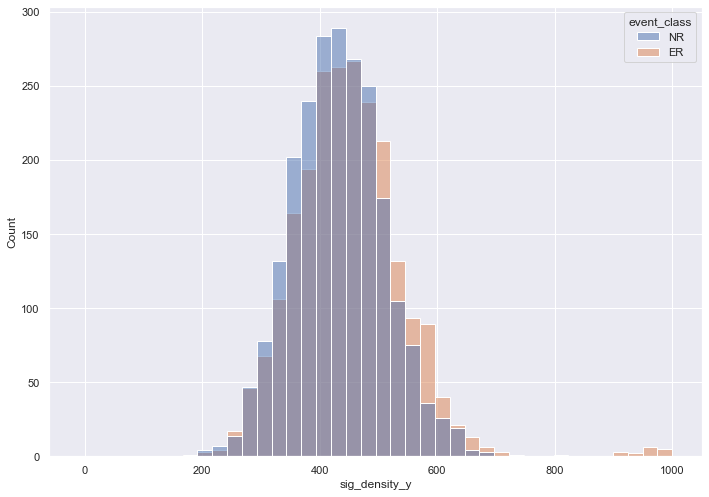

In [150]:
sns.histplot(x='sig_density_y', data=df.query('event_energy > 1 and event_energy < 30'), hue='event_class', bins=40, binrange=(-10, 1000))

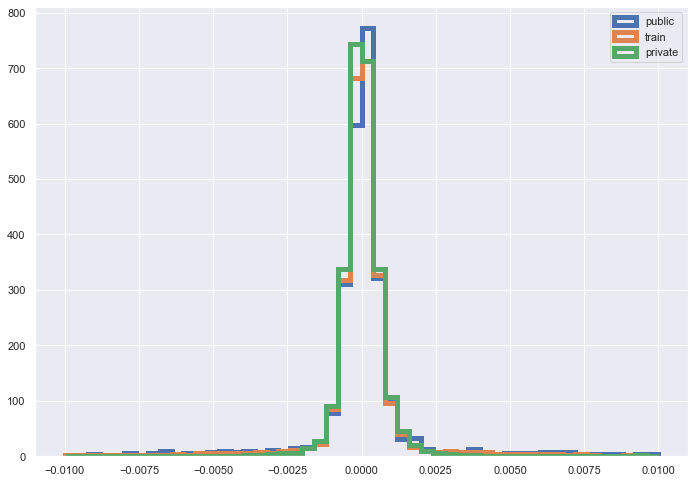

In [151]:
plt.hist(df_public.dfr, bins=50, range=(-.01, 0.01), linewidth=5, density=True, histtype='step', label='public')
plt.hist(df.dfr, bins=50, range=(-.01, 0.01), linewidth=5, density=True, histtype='step', label='train')
plt.hist(df_private.dfr, bins=50, range=(-.01, 0.01), linewidth=5, density=True, histtype='step', label='private')
plt.legend()
plt.show()